# **Nettoyage des données**


In [60]:
!pip install -r requirements.txt

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy import stats #(pour le calcul des fonctions de répartition)
from scipy.signal import savgol_filter

from Codes.scrpits_visualisations import (
    tracer_evolution,
    camembert,
    comparer_periodes
)



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\enriq\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [61]:
#Fonction pour tester tous les ARIMA possibles (somme dans le TD 4 du cours de STL)
from itertools import product

def evaluate_all_models(data, pmax=5, qmax=5, max_lag=15):
    """
    Teste automatiquement tous les ARIMA(p,0,q) pour p <= pmax et q <= qmax
    et retient ceux qui passent les critères :
    - Dernier AR significatif
    - Dernier MA significatif
    - Résidus ≈ bruit blanc (test de Ljung-Box)
    
    Paramètres:
    - data (pd.Series): série temporelle
    - pmax (int): ordre max pour p
    - qmax (int): ordre max pour q
    - max_lag (int): nombre de lags pour le test Ljung-Box
    
    Retourne:
    - modèles_valides (list): couples (p,q) qui passent les critères
    """
    modèles_valides = []
    
    # Générer toutes les combinaisons (p, q)
    all_pq = list(product(range(pmax+1), range(qmax+1)))

    for (p, q) in all_pq:
        if p == 0 and q == 0:
            continue  # Ne pas tester ARIMA(0,0,0)

        print(f"\nTest du modèle ARIMA({p},0,{q})")
        try:
            # Estimation du modèle
            model = ARIMA(data, order=(p, 0, q))
            fit = model.fit()

            # Résumé des coefficients
            coef = fit.params
            std_errors = fit.bse
            t_stats = coef / std_errors
            p_values = 2 * (1 - stats.norm.cdf(np.abs(t_stats)))
            summary = pd.DataFrame({
                'Coef': coef,
                'Std Err': std_errors,
                't-stat': t_stats,
                'p-value': p_values
            })

            # Vérification des p-values du dernier AR et MA
            ar_key = f'ar.L{p}'
            ma_key = f'ma.L{q}'
            
            ar_significatif = (p > 0 and ar_key in summary.index and summary.loc[ar_key, 'p-value'] < 0.05) or (p == 0)
            ma_significatif = (q > 0 and ma_key in summary.index and summary.loc[ma_key, 'p-value'] < 0.05) or (q == 0)
            
            # Test Ljung-Box global
            ljung = acorr_ljungbox(fit.resid, lags=[max_lag], return_df=True)
            ljung_pvalue = ljung.iloc[0]['lb_pvalue']
            ljung_test_ok = ljung_pvalue > 0.05

            # Résumé
            print(f" - Dernier AR significatif: {ar_significatif}")
            print(f" - Dernier MA significatif: {ma_significatif}")
            print(f" - Ljung-Box p-value = {ljung_pvalue:.4f} -> {'OK' if ljung_test_ok else 'Problème'}")

            if ar_significatif and ma_significatif and ljung_test_ok:
                print(" Modèle retenu.")
                modèles_valides.append((p, q))
            else:
                print(" Modèle rejeté.")

        except Exception as e:
            print(f" Problème sur ARIMA({p},0,{q}): {e}")
    
    print("\nRésumé : modèles retenus")
    print(modèles_valides)

    return modèles_valides


In [62]:
#Fonction pour calculer les AIC et BIC des modèles retenus par la fonction précédente
def compute_aic_bic(data, modèles, d=0):
    """
    Calcule AIC et BIC pour une liste de modèles ARIMA(p,d,q) donnés.

    Paramètres:
    - data (pd.Series): série temporelle
    - modèles (list of tuples): liste des (p,q) retenus
    - d (int): degré de différenciation (par défaut 0)
    
    Retourne:
    - results (pd.DataFrame): tableau AIC et BIC par modèle
    """
    résultats = []

    for (p, q) in modèles:
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            résultats.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': model.aic,
                'BIC': model.bic
            })
        except Exception as e:
            print(f" Problème pour ARIMA({p},{d},{q}): {e}")

    résultats_df = pd.DataFrame(résultats)
    résultats_df = résultats_df.sort_values(by='BIC').reset_index(drop=True)

    print("\nTableau AIC et BIC :")
    print(résultats_df)

    return résultats_df


In [63]:
def backcast_arima(df, col, order, trend=None):
    """
    Backcasting : prédit les valeurs manquantes au début de la série,
    en laissant le choix du trend (intercept/drift).

    Args
    ----
    df     : pd.DataFrame contenant la colonne à backcaster.
    col    : str, nom de la colonne (avec NaN au début).
    order  : tuple (p, d, q), ordre ARIMA.
    trend  : {'n', 'c', 't', 'ct'} ou None
             - None  : 'n' si d>0, sinon 'c' (ancien comportement)
             - 'n'   : pas d’intercept
             - 'c'   : intercept en niveaux
             - 't'   : drift (constante dans les différences)
             - 'ct'  : intercept + drift

    Returns
    -------
    pd.Series des valeurs backcastées alignées sur les NaN initiales.
    """
    y = df[col]
    first_valid_ix = y.first_valid_index()
    if first_valid_ix is None:
        raise ValueError("La série est entièrement NaN.")
    n_missing = y.index.get_loc(first_valid_ix)

    # Partie observée et inversion
    y_obs = y.iloc[n_missing:]
    y_rev = y_obs.iloc[::-1]

    # Choix automatique du trend si non précisé
    p, d, q = order
    if trend is None:
        trend = 'n' if d > 0 else 'c'

    # Ajustement et forecast
    model = ARIMA(y_rev, order=order, trend=trend)
    res   = model.fit()
    fc_rev = res.forecast(steps=n_missing)

    # Ré-inversion et alignement
    backcast = pd.Series(
        fc_rev.values[::-1],
        index=y.iloc[:n_missing].index,
        name=f'backcast_{col}'
    )
    return backcast


In [64]:
# Importation des données
df = pd.read_excel("Données_produites/base_de_données_v1.xlsx")


# Indexation
df = df.set_index('Unnamed: 0')

#Fonction qui construit un vecteur contenant le nom des variables
def variables_pays(pays):
    variable_pays=[f'CPI_{pays}',f'PIB_{pays}',f'LT_IR_{pays}',f'ST_IR_{pays}',f'WH_{pays}',f'P_Growth_{pays}']
    return(variable_pays)



## Etape 1: Eliminer les variables ayant trop de valeurs manquantes <a class="anchor" id="partie1"></a>

In [86]:
#On élimine l'année 1995 pour éviter de faire du "backcasting" du CPI de tous les pays
df_clean=df.copy()
df_clean=df_clean.drop(["1995-Q1","1995-Q2","1995-Q3","1995-Q4"])

#On élimine l'Estonie de notre dataset
Estonia=variables_pays("Estonia")
df_clean=df_clean.drop(Estonia, axis=1)
df_clean

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-Q1,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-Q2,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-Q3,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-Q4,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-Q1,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-Q4,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-Q1,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-Q2,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


In [87]:
# Les données de l'OCDE pour le CPI de la Suisse (méthodologie proche à celle d'Eurostat)
cpi_suisse = pd.read_csv(r"Données_extraites\CPI_Suisse_OCDE.csv")
cpi_suisse = cpi_suisse.pivot_table(index='TIME_PERIOD', columns='Reference area', values='OBS_VALUE')
cpi_suisse = cpi_suisse.drop(cpi_suisse.index[:4])


#On recopie ces données dans df_clean
df_clean['CPI_Switzerland']= cpi_suisse['Switzerland'].values
df_clean


,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-Q1,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-Q2,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-Q3,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-Q4,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-Q1,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-Q4,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-Q1,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-Q2,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


## Etape 2: détermination des modèles (ARMA et compagnie) pour nettoyer les données manquantes  <a class="anchor" id="partie2"></a>

In [9]:
# Clean values: format time series
df_clean_TS=df_clean.copy()
df_clean_TS.index = pd.PeriodIndex(df_clean.index, freq='Q')  #conversion en PeriodIndex
df_clean_TS.index = df_clean_TS.index.to_timestamp() #Conversion en DateTime

df_clean_TS


,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1996-01-01,71.553333,44641.2,6.396633,3.476667,39.8,2.573010,70.003333,54240.0,6.640000,3.350000,...,4.400333,NaN,37.000,1.317706,68.100000,262343.7,7.753200,6.277534,36.70,3.335283
1996-04-01,71.716667,46885.1,6.505600,3.266667,39.9,2.577419,70.516667,55590.7,6.713333,3.243333,...,4.546000,NaN,37.025,1.373025,68.866667,270422.9,8.067100,6.045267,36.65,3.286445
1996-07-01,71.763333,46969.6,6.430133,3.420000,40.0,2.580149,70.446667,53541.2,6.616667,3.230000,...,4.428000,NaN,37.050,1.426207,68.933333,277865.2,7.851067,5.840597,36.60,3.238139
1996-10-01,72.053333,47418.5,5.953500,3.330000,40.1,2.581239,70.936667,56570.4,6.000000,3.043333,...,4.160666,NaN,37.075,1.477287,69.366667,306097.3,7.569366,6.278986,36.55,3.190366
1997-01-01,72.463333,44369.0,5.709800,3.323333,40.2,2.580730,71.246667,53907.0,5.796667,3.203333,...,3.776333,NaN,37.100,1.526295,69.366667,323587.7,7.401933,6.335840,36.50,3.143125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,132.593333,122280.3,3.125533,3.957456,32.9,NaN,127.550000,158085.7,3.150000,3.957456,...,0.841333,1.718106,36.300,NaN,NaN,NaN,4.234600,5.326667,35.70,NaN
2024-01-01,133.326667,117154.2,2.835333,3.923615,34.0,NaN,129.700000,147812.8,2.890000,3.923615,...,0.765667,1.628413,35.700,NaN,NaN,NaN,4.029300,5.203333,35.70,NaN
2024-04-01,134.366667,120629.4,3.013533,3.808172,32.9,NaN,131.086667,154840.7,3.063333,3.808172,...,0.722333,1.475667,35.900,NaN,NaN,NaN,4.201500,5.166667,35.70,NaN


### LT_IR <a class="anchor" id="partie21"></a>

#### LT_IR_Latvia<a class="anchor" id="partie211"></a>

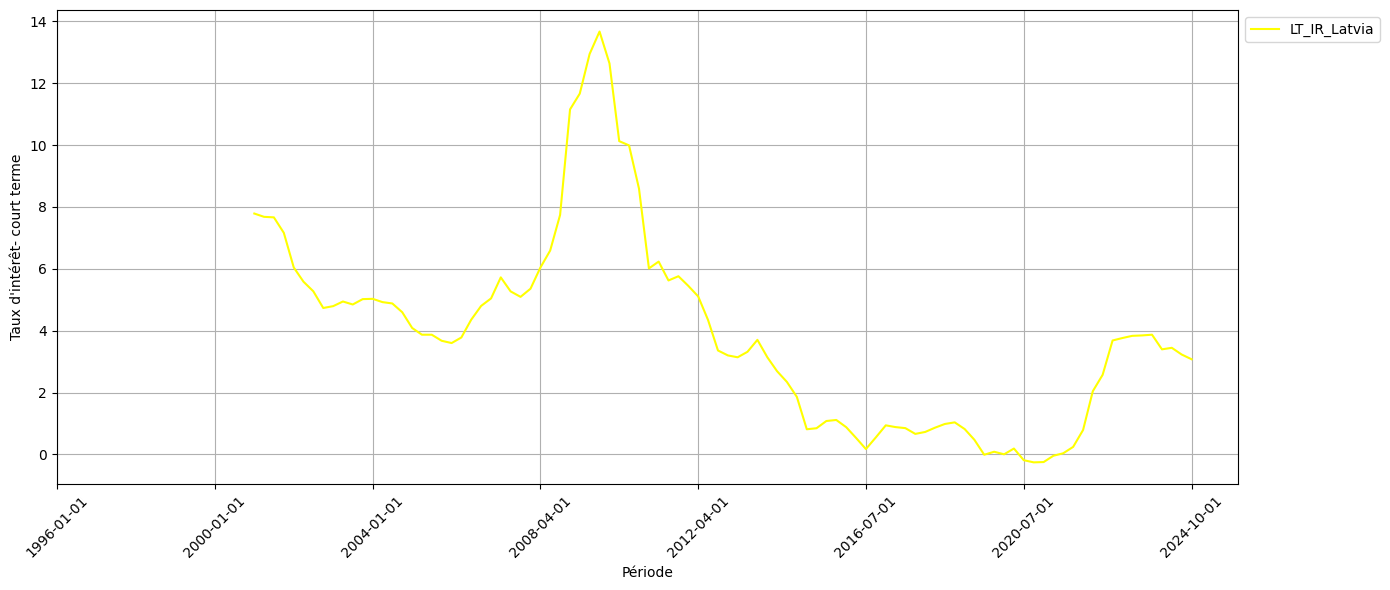

In [11]:
#Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS,["LT_IR_Latvia"], xlabel ="Période",ylabel = "Taux d'intérêt- court terme")


In [12]:
#Pour le moment la série ne semble avoir ni tendance ni saisonalité, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#La série n'est pas stationnaire
#essayons de faire une différenciation

ADF Statistic: -1.8849115861464936
p-value: 0.339192126932768


In [13]:
LT_IR_Latvia_diff=df_clean_TS["LT_IR_Latvia"].diff()
#LT_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

In [14]:
#Résult
result = adfuller(LT_IR_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
#On rejette à 5% l'hypothèse de non stationarité


ADF Statistic: -3.1602487301201223
p-value: 0.022404055416099515


<Figure size 1400x600 with 0 Axes>

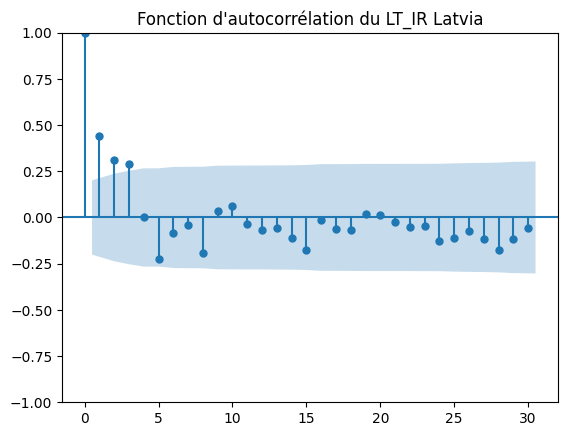

<Figure size 1400x600 with 0 Axes>

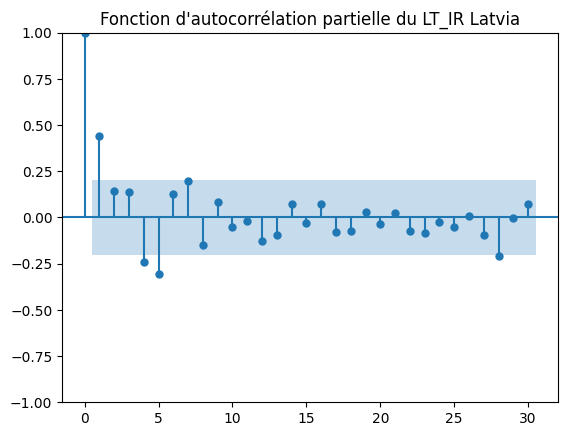

In [15]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR Latvia")
plt.show()


In [16]:
LT_IR_Latvia_models=evaluate_all_models(LT_IR_Latvia_diff.dropna(), 3, 5)


Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0144 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0051 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3579 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.2873 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.3701 -> OK
 Modèle retenu.

Test du modèle ARIMA(1,0,0)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0047 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(1,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 -

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0042 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0407 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(2,0,3)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.4542 -> OK
 Modèle rejeté.

Test du modèle ARIMA(2,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.7889 -> OK
 Modèle retenu.

Test du modèle ARIMA(2,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8758 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,0)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.0122 -> Problème
 Modèle rejeté.

Test du modèle ARIMA(3,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.0199

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.5589 -> OK
 Modèle retenu.

Test du modèle ARIMA(3,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.6247 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,4)
 - Dernier AR significatif: False
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.8787 -> OK
 Modèle rejeté.

Test du modèle ARIMA(3,0,5)
 - Dernier AR significatif: False
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8814 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 3), (0, 5), (2, 4), (3, 2)]


In [17]:
compute_aic_bic(LT_IR_Latvia_diff,LT_IR_Latvia_models,0)

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Tableau AIC et BIC :
   p  d  q         AIC         BIC
0  0  0  3  175.073290  188.841241
1  3  0  2  175.166795  194.441927
2  0  0  5  177.235480  196.510612
3  2  0  4  174.580233  196.608955


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,d,q,AIC,BIC
0,0,0,3,175.073290,188.841241
1,3,0,2,175.166795,194.441927
2,0,0,5,177.235480,196.510612
3,2,0,4,174.580233,196.608955


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

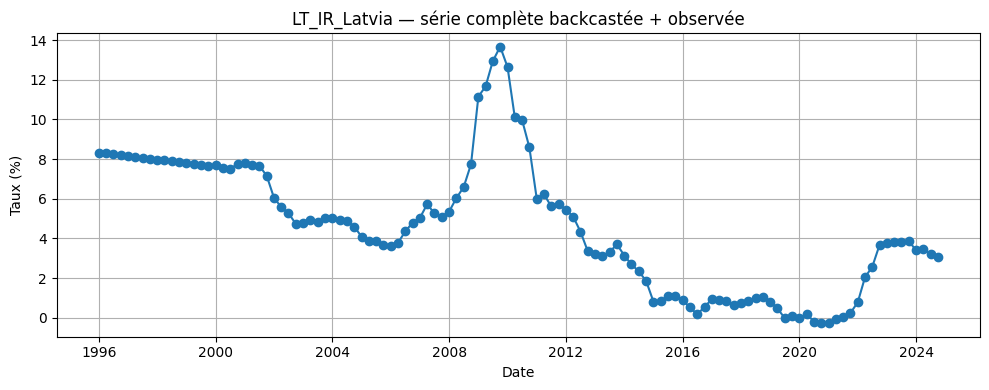

In [25]:
#On essaie d'appliquer la fonction précédente
#LT_IR_Latvia_pred=backcast_arima(df_clean_TS,"LT_IR_Latvia",(2,1,4))
LT_IR_Latvia_pred=backcast_arima(df_clean_TS, "LT_IR_Latvia", (2,1,4), trend='t')
LT_IR_Latvia_pred_final = LT_IR_Latvia_pred.combine_first(df_clean_TS["LT_IR_Latvia"])
LT_IR_Latvia_pred_final



# Si LT_IR_Latvia_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Latvia_pred_final.index, 
         LT_IR_Latvia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Latvia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



#### LT_IR_Lithuania<a class="anchor" id="partie212"></a>

In [ ]:
#Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS,["LT_IR_Lithuania"], xlabel ="Période",ylabel = "Taux d'intérêt- Long terme")

In [ ]:
#Pour le moment la série ne semble avoir ni tendance ni saisonalité, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

#La série n'est pas stationnaire
#essayons de faire une différenciation


In [ ]:
LT_IR_Lithuania_diff=df_clean_TS["LT_IR_Lithuania"].diff()
#LT_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Lithuania")
plt.show()

In [ ]:
#Résult
result = adfuller(LT_IR_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
#On rejette à 5% l'hypothèse de non stationarité


In [ ]:
LT_IR_Lithuania_models=evaluate_all_models(LT_IR_Lithuania_diff.dropna(), 4, 4)


In [ ]:
compute_aic_bic(LT_IR_Lithuania_diff,LT_IR_Lithuania_models,0)


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

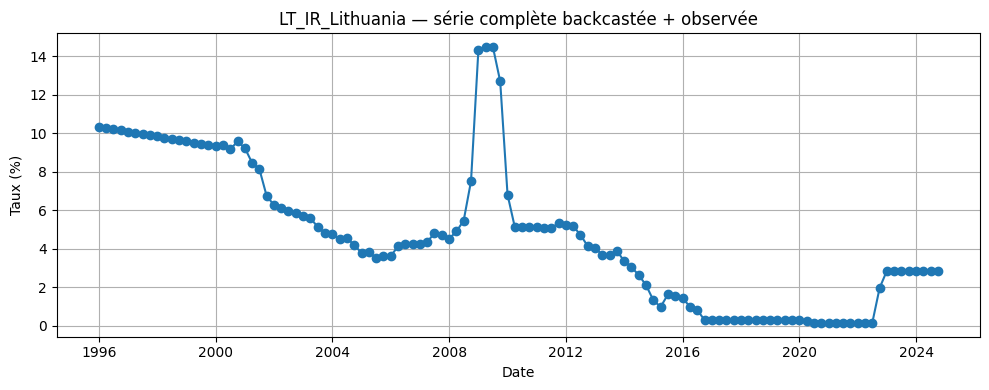

In [68]:
# LT_IR_Lithuania_pred = backcast_arima(df_clean_TS, "LT_IR_Lithuania", (0,1,4), trend='t')
LT_IR_Lithuania_pred = backcast_arima(df_clean_TS, "LT_IR_Lithuania", (0,1,4), trend='t')
LT_IR_Lithuania_pred_final = LT_IR_Lithuania_pred.combine_first(df_clean_TS["LT_IR_Lithuania"])

# Si LT_IR_Lithuania_pred_final est un pd.Series indexé en datetime :
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Lithuania_pred_final.index, 
         LT_IR_Lithuania_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Lithuania — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### LT_IR_Poland<a class="anchor" id="partie213"></a>

In [ ]:
# Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS, ["LT_IR_Poland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

In [ ]:
#La série semble avoir une tendance décroissante, essayons d'appliquer un test ADF
result = adfuller(df_clean_TS["LT_IR_Poland"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# La série n'est pas stationnaire
# Essayons de faire une différenciation

In [ ]:
LT_IR_Poland_diff = df_clean_TS["LT_IR_Poland"].diff()
LT_IR_Poland_diff.plot(title="Taux d'intérêt Pologne différencié", figsize=(12, 4))
# La série semble centrée en 0, mais avec une légère tendance à la hausse

In [ ]:
# Résultat du test ADF sur la série différenciée
result = adfuller(LT_IR_Poland_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# On rejette à 5% l'hypothèse de non stationnarité

In [ ]:

plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Poland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR Poland")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Poland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR Poland")
plt.show()

In [ ]:
LT_IR_Poland_models = evaluate_all_models(LT_IR_Poland_diff.dropna(), 1, 2)
#Les ordres conservés: (1,2)

In [ ]:
compute_aic_bic(LT_IR_Poland_diff, LT_IR_Poland_models, 0)
#Modèle retenu selon le criètere BIC


In [72]:
# On essaie d'appliquer la fonction backcast
LT_IR_Poland_pred = backcast_arima(df_clean_TS, "LT_IR_Poland", (1,1,0), trend='t')
LT_IR_Poland_pred_final = LT_IR_Poland_pred.combine_first(df_clean_TS["LT_IR_Poland"])
LT_IR_Poland_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    11.071866
1996-04-01    11.025739
1996-07-01    10.979612
1996-10-01    10.933486
1997-01-01    10.887359
                ...    
2023-10-01     5.530000
2024-01-01     5.333333
2024-04-01     5.690000
2024-07-01     5.413333
2024-10-01     5.663333
Freq: QS-OCT, Name: backcast_LT_IR_Poland, Length: 116, dtype: float64

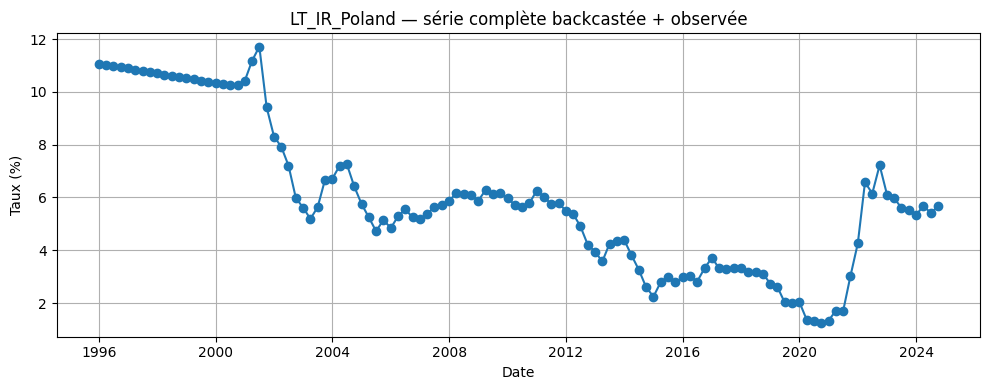

In [73]:
# Si LT_IR_Poland_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Poland_pred_final.index, 
         LT_IR_Poland_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Poland — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Slovakia<a class="anchor" id="partie214"></a>

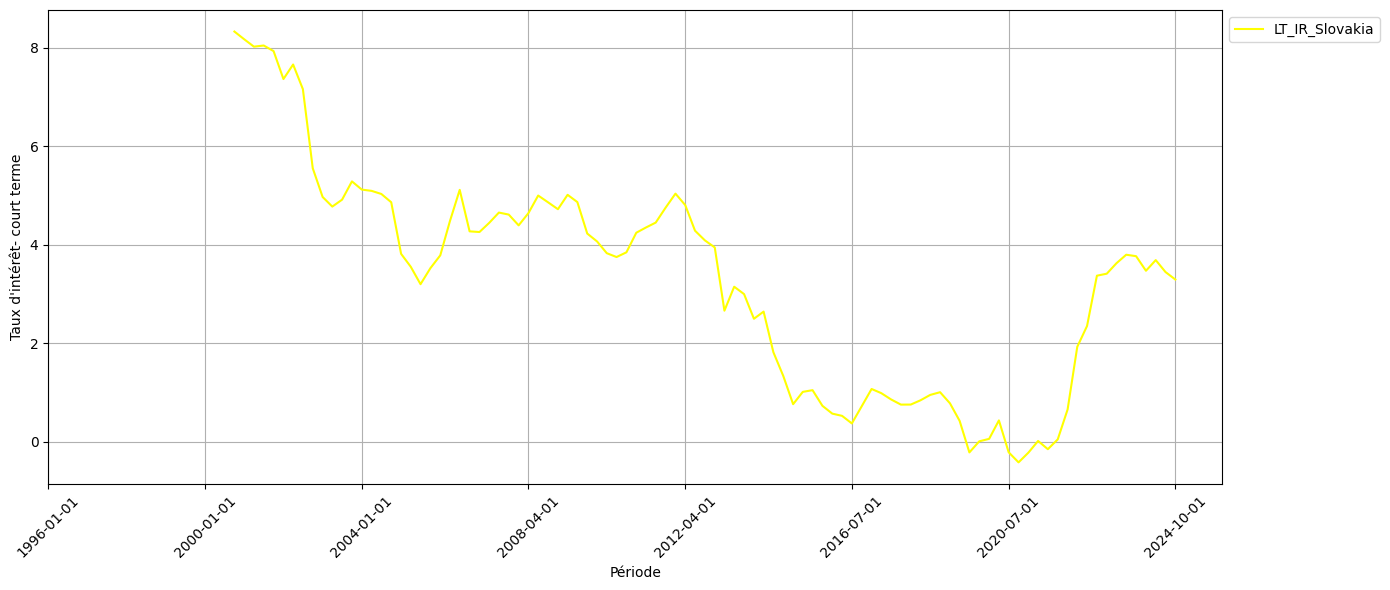

In [26]:
# Le code qui suit sert uniquement à visualiser les ST
# syntaxe: tracer_evolution(df, columns=None, xlabel= None, ylabel=None, start_date=None, end_date=None, log=False, base=None, lissage=False):
tracer_evolution(df_clean_TS, ["LT_IR_Slovakia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

In [27]:
# Pour le moment la série semble avoir une tendane décroissante. Appliquons un ADF
result = adfuller(df_clean_TS["LT_IR_Slovakia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# La série n'est pas stationnaire
# Essayons de faire une différenciation

ADF Statistic: -2.28379394050597
p-value: 0.1772480300529503


<Axes: title={'center': "Taux d'intérêt Slovaquie différencié"}, xlabel='Unnamed: 0'>

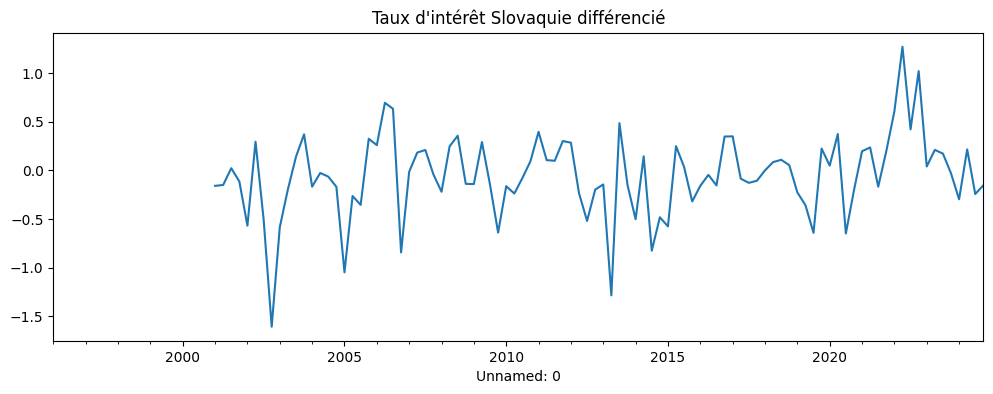

In [28]:
LT_IR_Slovakia_diff = df_clean_TS["LT_IR_Slovakia"].diff()
LT_IR_Slovakia_diff.plot(title="Taux d'intérêt Slovaquie différencié", figsize=(12, 4))


In [31]:
# Résultat du test ADF sur la série différenciée
result = adfuller(LT_IR_Slovakia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
# On rejette à 5% l'hypothèse de non stationnarité

ADF Statistic: -7.392895562566153
p-value: 7.915058713534137e-11


In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Slovakia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Slovakia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Slovakia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Slovakia")
plt.show()

In [ ]:
#modèles retenus: (1,1)
LT_IR_Slovakia_models = evaluate_all_models(LT_IR_Slovakia_diff.dropna(), 1, 1)


In [ ]:
compute_aic_bic(LT_IR_Slovakia_diff, LT_IR_Slovakia_models, 0)

In [69]:
# On essaie d'appliquer la fonction précédente
# LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1))
LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1), trend='t')
LT_IR_Slovakia_pred_final = LT_IR_Slovakia_pred.combine_first(df_clean_TS["LT_IR_Slovakia"])
LT_IR_Slovakia_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    9.351080
1996-04-01    9.298318
1996-07-01    9.245556
1996-10-01    9.192794
1997-01-01    9.140032
                ...   
2023-10-01    3.766608
2024-01-01    3.470253
2024-04-01    3.687122
2024-07-01    3.444584
2024-10-01    3.291885
Freq: QS-OCT, Name: backcast_LT_IR_Slovakia, Length: 116, dtype: float64

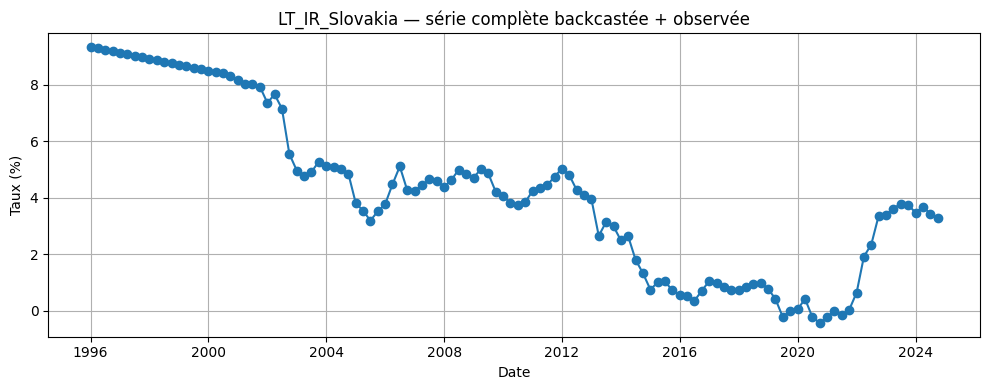

In [70]:
# Si LT_IR_Slovakia_pred_final est un pd.Series indexé en datetime :
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Slovakia_pred_final.index, 
         LT_IR_Slovakia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Slovakia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

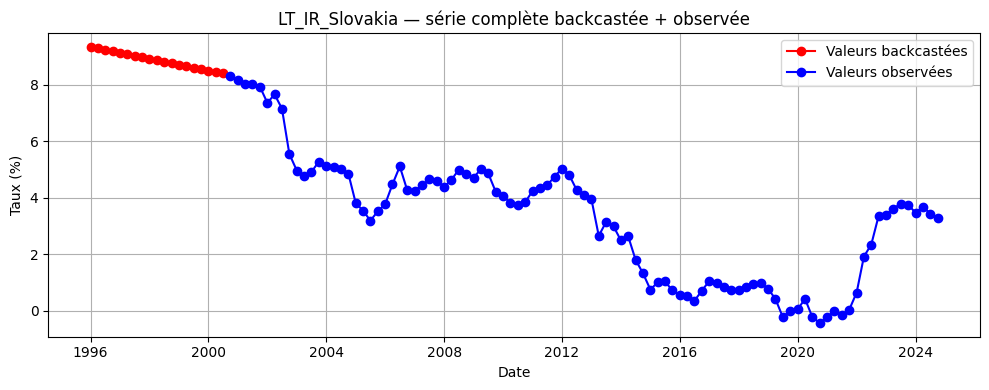

In [74]:
# On applique le backcast
LT_IR_Slovakia_pred = backcast_arima(df_clean_TS, "LT_IR_Slovakia", (0,1,1), trend='t')
LT_IR_Slovakia_pred_final = LT_IR_Slovakia_pred.combine_first(df_clean_TS["LT_IR_Slovakia"])

# Tracé
plt.figure(figsize=(10, 4))

# Partie backcastée (rouge)
plt.plot(LT_IR_Slovakia_pred.index, 
         LT_IR_Slovakia_pred.values, 
         marker='o', linestyle='-', color='red', label='Valeurs backcastées')

# Partie observée (bleu)
plt.plot(df_clean_TS["LT_IR_Slovakia"].index, 
         df_clean_TS["LT_IR_Slovakia"].values, 
         marker='o', linestyle='-', color='blue', label='Valeurs observées')

# Mise en forme
plt.title("LT_IR_Slovakia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### LT_IR_Czechia<a class="anchor" id="partie215"></a>
Attention: aucun modèle ne passe tous les tests malheuresement, on a gardé celui obtenu visuellement à partir de ACF et PACF

In [ ]:
tracer_evolution(df_clean_TS, ["LT_IR_Czechia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["LT_IR_Czechia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
LT_IR_Czechia_diff = df_clean_TS["LT_IR_Czechia"].diff()
LT_IR_Czechia_diff.plot(title="Taux d'intérêt Chéquie différencié", figsize=(12, 4))

result = adfuller(LT_IR_Czechia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Czechia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Czechia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Czechia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Czechia")
plt.show()

In [ ]:
LT_IR_Czechia_models = evaluate_all_models(LT_IR_Czechia_diff.dropna(), 5, 0)
# Problème: aucun modèle n'est retenu à la fin, on va tout de même garder le modèle (5,1,0)

In [ ]:

LT_IR_Czechia_pred = backcast_arima(df_clean_TS, "LT_IR_Czechia", (5,1,0), trend='t')
LT_IR_Czechia_pred_final = LT_IR_Czechia_pred.combine_first(df_clean_TS["LT_IR_Czechia"])
LT_IR_Czechia_pred_final

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Czechia_pred_final.index, 
         LT_IR_Czechia_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Czechia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Hungary<a class="anchor" id="partie216"></a>


In [ ]:
tracer_evolution(df_clean_TS, ["LT_IR_Hungary"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["LT_IR_Hungary"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
LT_IR_Hungary_diff = df_clean_TS["LT_IR_Hungary"].diff()
LT_IR_Hungary_diff.plot(title="Taux d'intérêt Hongrie différencié", figsize=(12, 4))


result = adfuller(LT_IR_Hungary_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Hungary_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Hungary")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Hungary_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Hungary")
plt.show()

In [ ]:
LT_IR_Hungary_models = evaluate_all_models(LT_IR_Hungary_diff.dropna(), 3, 1)


In [ ]:
compute_aic_bic(LT_IR_Hungary_diff, LT_IR_Hungary_models, 0)


In [ ]:
LT_IR_Hungary_pred = backcast_arima(df_clean_TS, "LT_IR_Hungary", (1,1,0), trend='t')
LT_IR_Hungary_pred_final = LT_IR_Hungary_pred.combine_first(df_clean_TS["LT_IR_Hungary"])
LT_IR_Hungary_pred_final

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Hungary_pred_final.index, 
         LT_IR_Hungary_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Hungary — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### LT_IR_Iceland<a class="anchor" id="partie217"></a>
Ceci est à compléter.... il faut modifier la fonction du backcast, mais cette fois-ci pour faire du forecast

In [ ]:
tracer_evolution(df_clean_TS, ["LT_IR_Iceland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")


#### LT_IR_Greece<a class="anchor" id="partie218"></a>
rq: de loin la meilleure prédiction

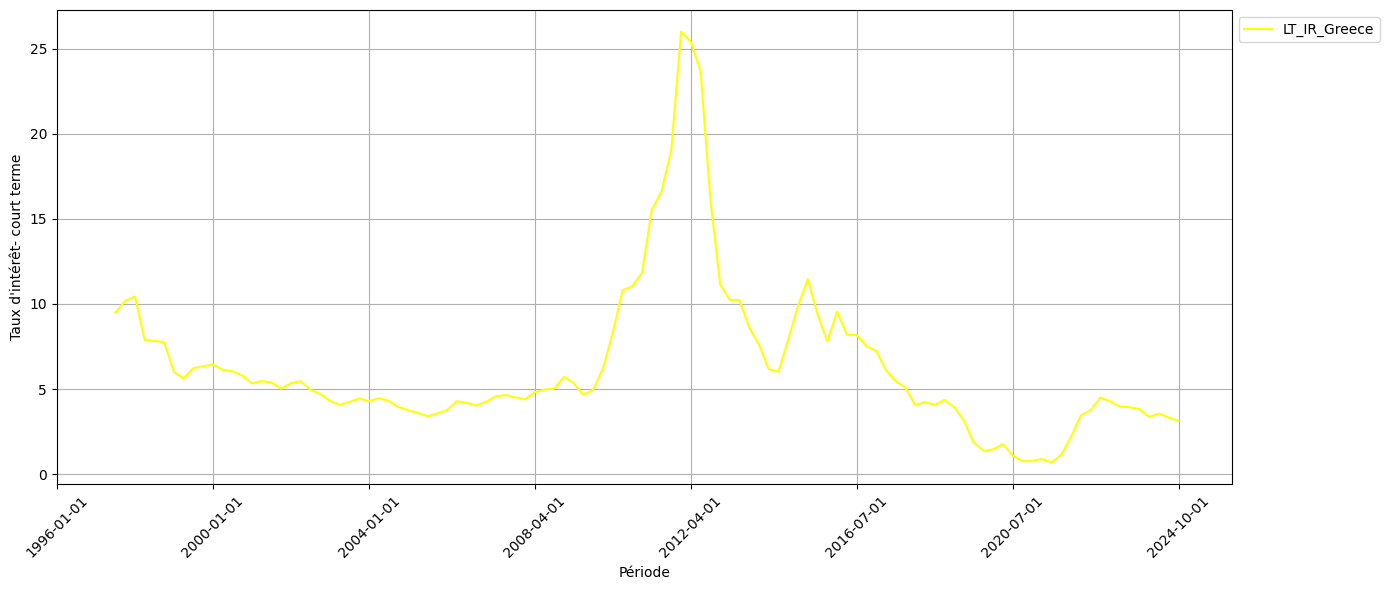

ADF Statistic: -2.7517044559953177
p-value: 0.06551044914612564


In [19]:
tracer_evolution(df_clean_TS, ["LT_IR_Greece"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["LT_IR_Greece"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [20]:
LT_IR_Greece_diff = df_clean_TS["LT_IR_Greece"].diff()
result = adfuller(LT_IR_Greece_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -6.362258064818379
p-value: 2.458013571421394e-08


<Figure size 1400x600 with 0 Axes>

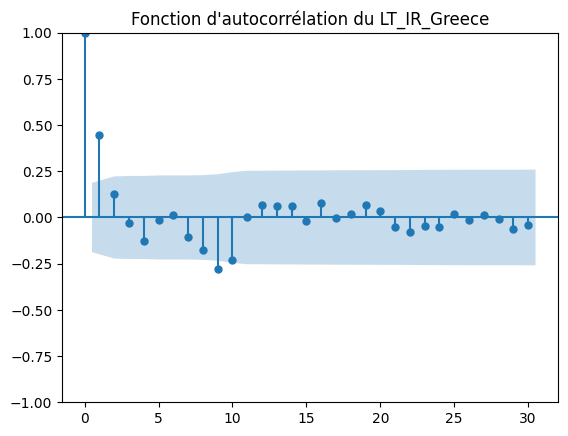

<Figure size 1400x600 with 0 Axes>

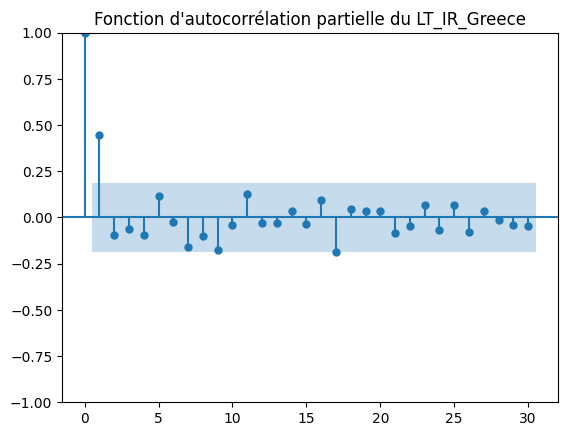

In [21]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(LT_IR_Greece_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du LT_IR_Greece")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(LT_IR_Greece_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du LT_IR_Greece")
plt.show()

In [22]:
LT_IR_Greece_models = evaluate_all_models(LT_IR_Greece_diff.dropna(), 1, 9)



Test du modèle ARIMA(0,0,1)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2464 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,2)
 - Dernier AR significatif: True
 - Dernier MA significatif: True
 - Ljung-Box p-value = 0.2861 -> OK
 Modèle retenu.

Test du modèle ARIMA(0,0,3)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.4212 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,4)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.6855 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,5)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7192 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,6)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.7196 -> OK
 Modèle rejeté.

Test du modèle ARIMA(0,0,7)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-val

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.8789 -> OK
 Modèle rejeté.

Test du modèle ARIMA(1,0,9)
 - Dernier AR significatif: True
 - Dernier MA significatif: False
 - Ljung-Box p-value = 0.9876 -> OK
 Modèle rejeté.

Résumé : modèles retenus
[(0, 1), (0, 2), (1, 0)]


C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
compute_aic_bic(LT_IR_Greece_diff, LT_IR_Greece_models, 0)


In [23]:
LT_IR_Greece_pred = backcast_arima(df_clean_TS, "LT_IR_Greece", (2,1,4), trend='t')
LT_IR_Greece_pred_final = LT_IR_Greece_pred.combine_first(df_clean_TS["LT_IR_Greece"])
LT_IR_Greece_pred_final

C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\enriq\AppData

Unnamed: 0
1996-01-01    8.415883
1996-04-01    8.420156
1996-07-01    8.431223
1996-10-01    8.440904
1997-01-01    8.491149
                ...   
2023-10-01    3.820000
2024-01-01    3.370000
2024-04-01    3.563333
2024-07-01    3.333333
2024-10-01    3.133333
Freq: QS-OCT, Name: backcast_LT_IR_Greece, Length: 116, dtype: float64

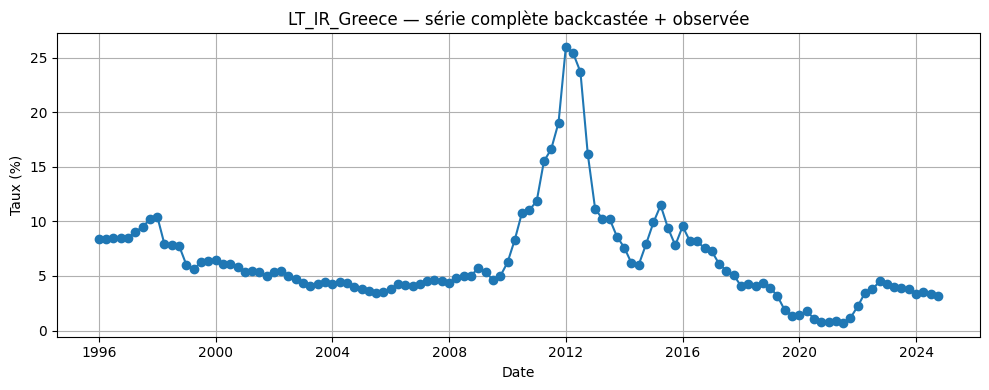

In [24]:
plt.figure(figsize=(10, 4))
plt.plot(LT_IR_Greece_pred_final.index, 
         LT_IR_Greece_pred_final.values, 
         marker='o', linestyle='-')
plt.title("LT_IR_Greece — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

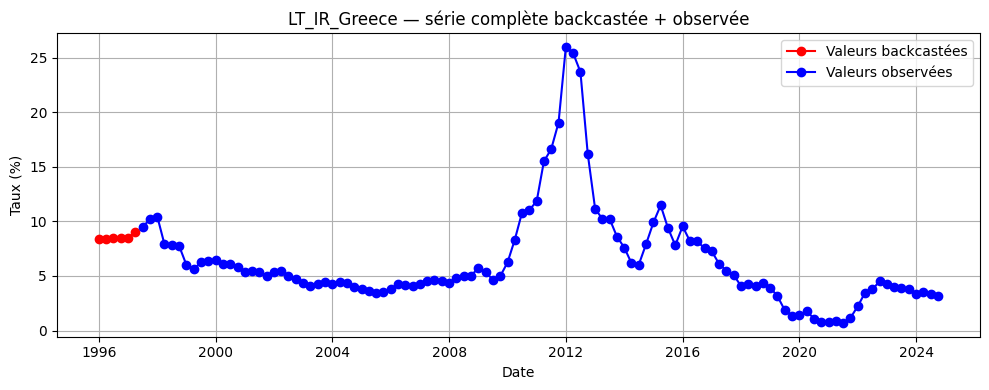

In [67]:
# On crée une figure
plt.figure(figsize=(10, 4))

# Partie backcastée uniquement (les prédictions)
plt.plot(LT_IR_Greece_pred.index, 
         LT_IR_Greece_pred.values, 
         marker='o', linestyle='-', color='red', label='Valeurs backcastées')

# Partie observée
plt.plot(df_clean_TS["LT_IR_Greece"].index, 
         df_clean_TS["LT_IR_Greece"].values, 
         marker='o', linestyle='-', color='blue', label='Valeurs observées')

# Mise en forme
plt.title("LT_IR_Greece — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### WH <a class="anchor" id="partie22"></a>

Il y a une composante saisonnière dans chacune des séries. Il faudra modifier le programme de base

#### WH_Bulgaria <a class="anchor" id="partie221"></a>

In [ ]:
tracer_evolution(df_clean_TS, ["WH_Bulgaria"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["WH_Bulgaria"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
WH_Bulgaria_diff = df_clean_TS["WH_Bulgaria"].diff()
WH_Bulgaria_diff.plot(title="Taux d'intérêt Bulgarie différencié", figsize=(12, 4)) 

result = adfuller(WH_Bulgaria_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Bulgaria_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Bulgaria")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Bulgaria_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Bulgaria")
plt.show()

In [ ]:
WH_Bulgaria_models = evaluate_all_models(WH_Bulgaria_diff.dropna(), 3, 8)

In [ ]:
compute_aic_bic(WH_Bulgaria_diff, WH_Bulgaria_models, 0)


In [ ]:
WH_Bulgaria_pred = backcast_arima(df_clean_TS, "WH_Bulgaria", (3,1,0), trend='t')
WH_Bulgaria_pred_final = WH_Bulgaria_pred.combine_first(df_clean_TS["WH_Bulgaria"])

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(WH_Bulgaria_pred_final.index, WH_Bulgaria_pred_final.values, marker='o', linestyle='-')
plt.title("WH_Bulgaria — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### WH_Lithuania <a class="anchor" id="partie222"></a>
ATTENTION, la série différenciée ne rejette pas le test ADF
Cette série a une composante saisonnière: on laisse tomber pour le moment

In [ ]:
tracer_evolution(df_clean_TS, ["WH_Lithuania"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["WH_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
WH_Lithuania_diff = df_clean_TS["WH_Lithuania"].shift(4)  # saisonnalité
WH_Lithuania_diff = df_clean_TS["WH_Lithuania"] - WH_Lithuania_diff
WH_Lithuania_diff = WH_Lithuania_diff - WH_Lithuania_diff.shift(1)  # tendance


WH_Lithuania_diff.plot(title="Taux d'intérêt Lituanie différencié", figsize=(12, 4)) 

result = adfuller(WH_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Lithuania")
plt.show()

In [ ]:
WH_Lithuania_models = evaluate_all_models(WH_Lithuania_diff.dropna(), 13, 16)


#### WH_Latvia <a class="anchor" id="partie223"></a>

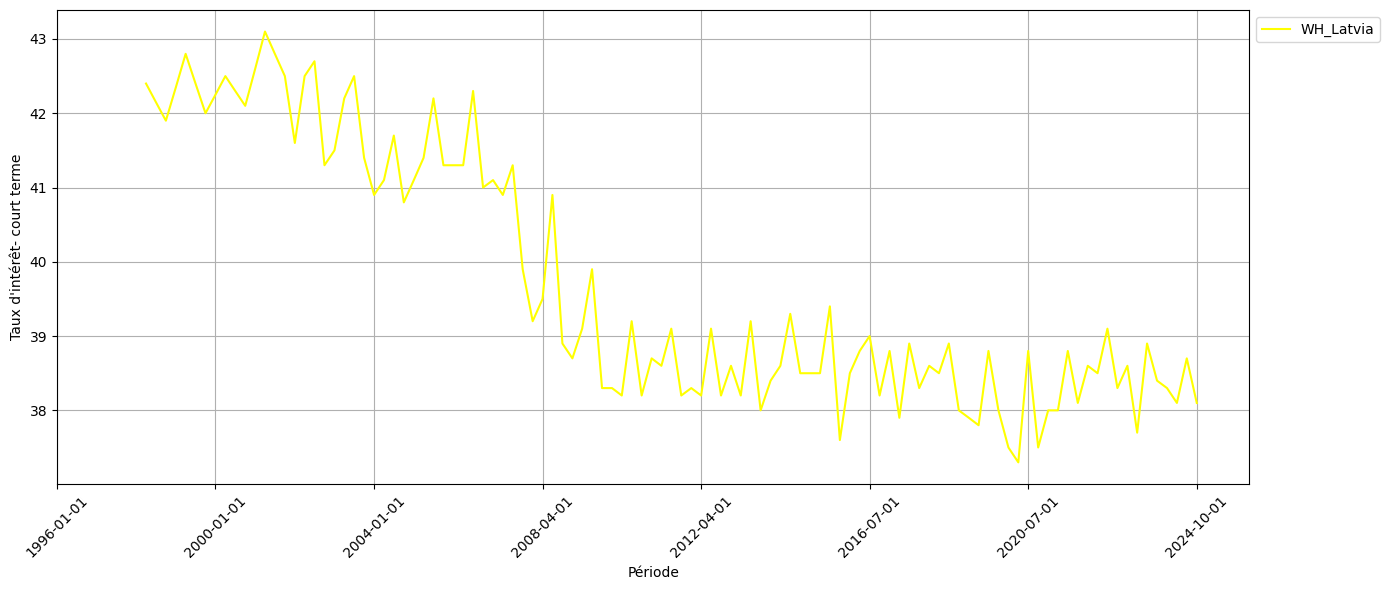

ADF Statistic: -1.8195039374033954
p-value: 0.370822421215641


In [32]:
tracer_evolution(df_clean_TS, ["WH_Latvia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")

result = adfuller(df_clean_TS["WH_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
WH_Latvia_diff = df_clean_TS["WH_Latvia"].diff()
WH_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4)) 

result = adfuller(WH_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(WH_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du WH_Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(WH_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du WH_Latvia")
plt.show()

#### WH_Slovakia <a class="anchor" id="partie224"></a>

#### WH_Poland <a class="anchor" id="partie225"></a>

#### WH_Czechia <a class="anchor" id="partie226"></a>

#### WH_Romania <a class="anchor" id="partie227"></a>

### ST_IR <a class="anchor" id="partie23"></a>

#### ST_IR_Switzerland <a class="anchor" id="partie231"></a>

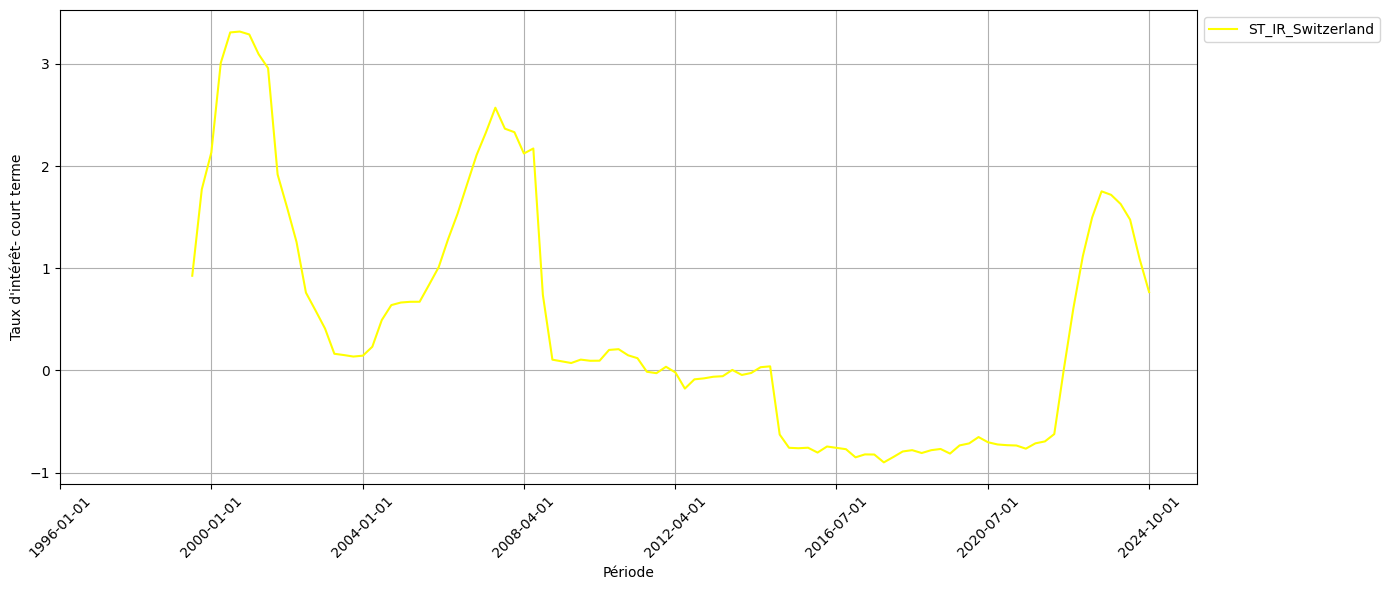

ADF Statistic: -2.5857713058530982
p-value: 0.09597385312741918


In [33]:
tracer_evolution(df_clean_TS, ["ST_IR_Switzerland"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Switzerland"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.894813968751875
p-value: 2.8679604111724724e-07


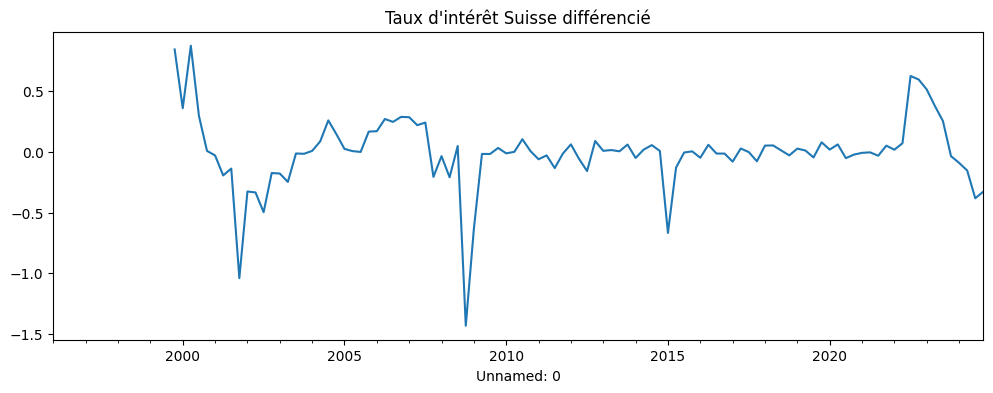

In [34]:
ST_IR_Switzerland_diff = df_clean_TS["ST_IR_Switzerland"].diff()
ST_IR_Switzerland_diff.plot(title="Taux d'intérêt Suisse différencié", figsize=(12, 4))
result = adfuller(ST_IR_Switzerland_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

<Figure size 1400x600 with 0 Axes>

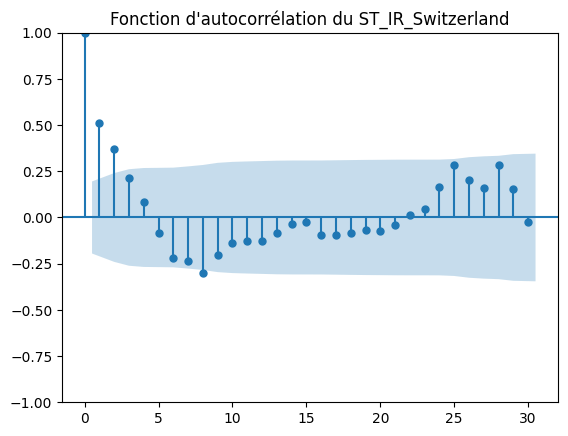

<Figure size 1400x600 with 0 Axes>

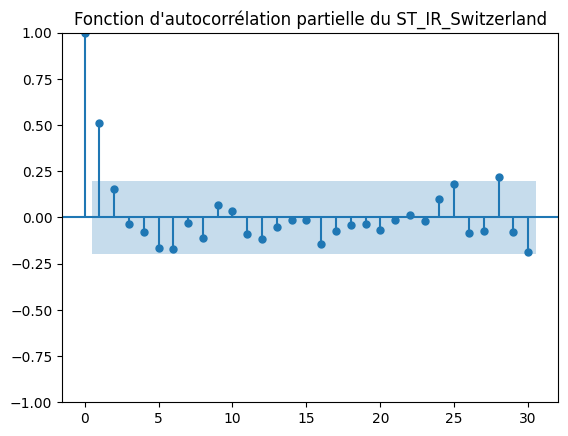

In [35]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Switzerland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Switzerland")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Switzerland_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Switzerland")
plt.show()

In [ ]:
ST_IR_Switzerland_models = evaluate_all_models(ST_IR_Switzerland_diff.dropna(), 1, 2)


In [ ]:
compute_aic_bic(ST_IR_Switzerland_diff, ST_IR_Switzerland_models, 0)


In [ ]:
ST_IR_Switzerland_pred = backcast_arima(df_clean_TS, "ST_IR_Switzerland", (1,1,0), trend='t')
ST_IR_Switzerland_pred_final = ST_IR_Switzerland_pred.combine_first(df_clean_TS["ST_IR_Switzerland"])

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Switzerland_pred_final.index, ST_IR_Switzerland_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Switzerland — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Lithuania <a class="anchor" id="partie232"></a>

In [ ]:


tracer_evolution(df_clean_TS, ["ST_IR_Lithuania"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Lithuania"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
ST_IR_Lithuania_diff = df_clean_TS["ST_IR_Lithuania"].diff()
ST_IR_Lithuania_diff.plot(title="Taux d'intérêt Lituanie différencié", figsize=(12, 4))

result = adfuller(ST_IR_Lithuania_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Lithuania")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Lithuania_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Lithuania")
plt.show()


In [ ]:
ST_IR_Lithuania_models = evaluate_all_models(ST_IR_Lithuania_diff.dropna(), 2, 1)


In [ ]:
compute_aic_bic(ST_IR_Lithuania_diff, ST_IR_Lithuania_models, 0)


In [ ]:
ST_IR_Lithuania_pred = backcast_arima(df_clean_TS, "ST_IR_Lithuania", (0,1,1), trend='t')
ST_IR_Lithuania_pred_final = ST_IR_Lithuania_pred.combine_first(df_clean_TS["ST_IR_Lithuania"])


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Lithuania_pred_final.index, ST_IR_Lithuania_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Lithuania — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Luxembourg <a class="anchor" id="partie233"></a>

In [ ]:
tracer_evolution(df_clean_TS, ["ST_IR_Luxembourg"], xlabel="Période", ylabel="Taux d'intérêt- court terme")
result = adfuller(df_clean_TS["ST_IR_Luxembourg"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
ST_IR_Luxembourg_diff = df_clean_TS["ST_IR_Luxembourg"].diff()
ST_IR_Luxembourg_diff.plot(title="Taux d'intérêt Luxembourg différencié", figsize=(12, 4))

result = adfuller(ST_IR_Luxembourg_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Luxembourg_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Luxembourg")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Luxembourg_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Luxembourg")
plt.show()

In [ ]:
ST_IR_Luxembourg_models = evaluate_all_models(ST_IR_Luxembourg_diff.dropna(), 5, 2)


In [ ]:
compute_aic_bic(ST_IR_Luxembourg_diff, ST_IR_Luxembourg_models, 0)


In [ ]:
ST_IR_Luxembourg_pred = backcast_arima(df_clean_TS, "ST_IR_Luxembourg", (1,1,0), trend='t')
ST_IR_Luxembourg_pred_final = ST_IR_Luxembourg_pred.combine_first(df_clean_TS["ST_IR_Luxembourg"])


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Luxembourg_pred_final.index, ST_IR_Luxembourg_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Luxembourg — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### ST_IR_Latvia <a class="anchor" id="partie233"></a>

In [ ]:
tracer_evolution(df_clean_TS, ["ST_IR_Latvia"], xlabel="Période", ylabel="Taux d'intérêt- court terme")


result = adfuller(df_clean_TS["ST_IR_Latvia"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
ST_IR_Latvia_diff = df_clean_TS["ST_IR_Latvia"].diff()
ST_IR_Latvia_diff.plot(title="Taux d'intérêt Lettonie différencié", figsize=(12, 4))

result = adfuller(ST_IR_Latvia_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
plt.figure(figsize=(14,6))
tsaplots.plot_acf(ST_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation du ST_IR_Latvia")
plt.show()

plt.figure(figsize=(14,6))
tsaplots.plot_pacf(ST_IR_Latvia_diff.dropna(), lags=30)
plt.title("Fonction d'autocorrélation partielle du ST_IR_Latvia")
plt.show()

In [ ]:
ST_IR_Latvia_models = evaluate_all_models(ST_IR_Latvia_diff.dropna(), 5, 5)


In [ ]:
compute_aic_bic(ST_IR_Latvia_diff, ST_IR_Latvia_models, 0)


In [ ]:
ST_IR_Latvia_pred = backcast_arima(df_clean_TS, "ST_IR_Latvia", (1,1,2), trend='t')
ST_IR_Latvia_pred_final = ST_IR_Latvia_pred.combine_first(df_clean_TS["ST_IR_Latvia"])


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ST_IR_Latvia_pred_final.index, ST_IR_Latvia_pred_final.values, marker='o', linestyle='-')
plt.title("ST_IR_Latvia — série complète backcastée + observée")
plt.xlabel("Date")
plt.ylabel("Taux (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### P_Growth <a class="anchor" id="partie24"></a>

In [ ]:
from numpy.polynomial import Polynomial

def forecast_polynomial(df, col, degree=3):
    """
    Remplit les NaN à la fin d'une série par une régression polynomiale.

    Paramètres :
    - df : DataFrame contenant la série
    - col : nom de la colonne cible
    - degree : degré du polynôme à ajuster

    Retour :
    - pd.Series complète avec prédiction sur les NaN de fin
    """
    y = df[col]
    valid_y = y.dropna()
    
    if len(valid_y) < degree + 1:
        raise ValueError("Pas assez de points pour ajuster un polynôme.")

    # Indices des points observés
    x_obs = np.arange(len(valid_y))
    y_obs = valid_y.values

    # Ajustement polynômial
    poly = Polynomial.fit(x_obs, y_obs, deg=degree)

    # Indices de toute la série
    x_full = np.arange(len(y))
    y_pred_full = poly(x_full)

    # Création de la série prédite
    y_pred_series = pd.Series(y_pred_full, index=y.index, name=col)

    # Remplissage uniquement des NaN à la fin
    return y.combine_first(y_pred_series)

df_clean_TS

In [ ]:
#Nous allons automatiser le processus de complétion des données manquantes pour la croissance potentielle. 
def forecast_polynomial_automation(df, noms_pays):
    result={}
    for country in noms_pays:
        nouvelle_series=forecast_polynomial(df,f'P_Growth_{country}')
        result[f'P_Growth_{country}']=nouvelle_series
    final_df=pd.DataFrame(result)
    return final_df


countries_selected=[
    "Austria", "Belgium", "Bulgaria", "Czechia", "Denmark", 
    "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", 
    "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Netherlands", 
    "Norway", "Poland", "Portugal", "Romania", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland", "United_Kingdom"
]

P_Growth_forecasts=forecast_polynomial_automation(df_clean_TS,countries_selected)
P_Growth_forecasts



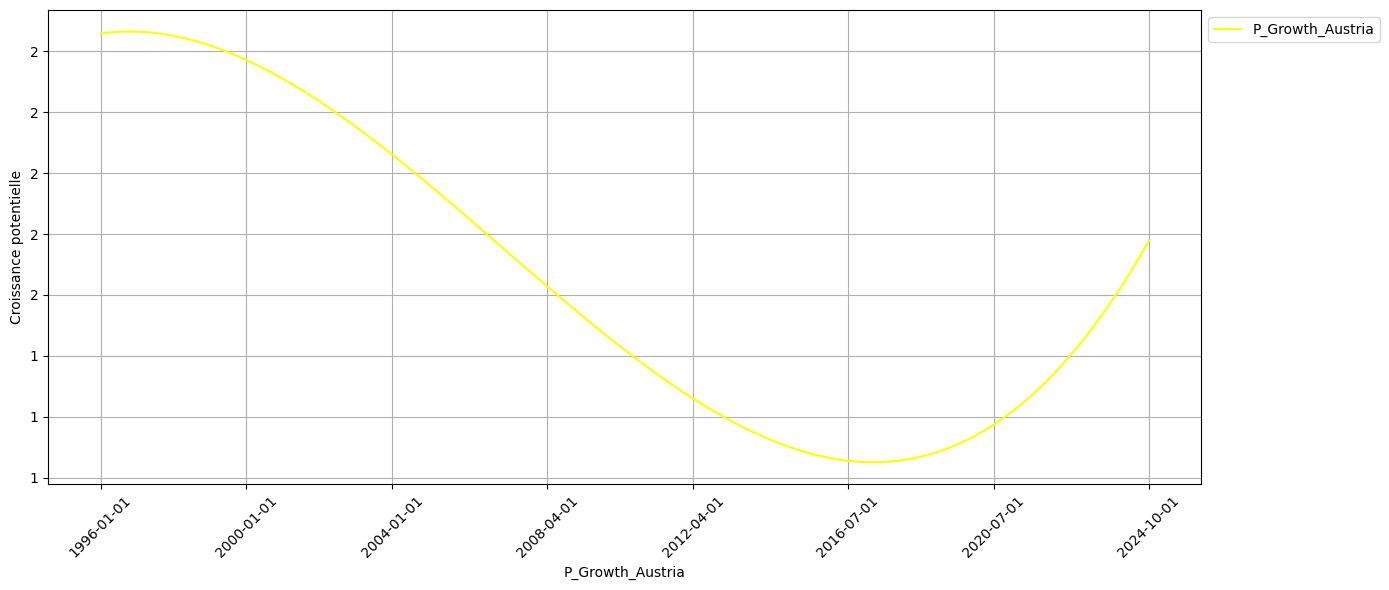

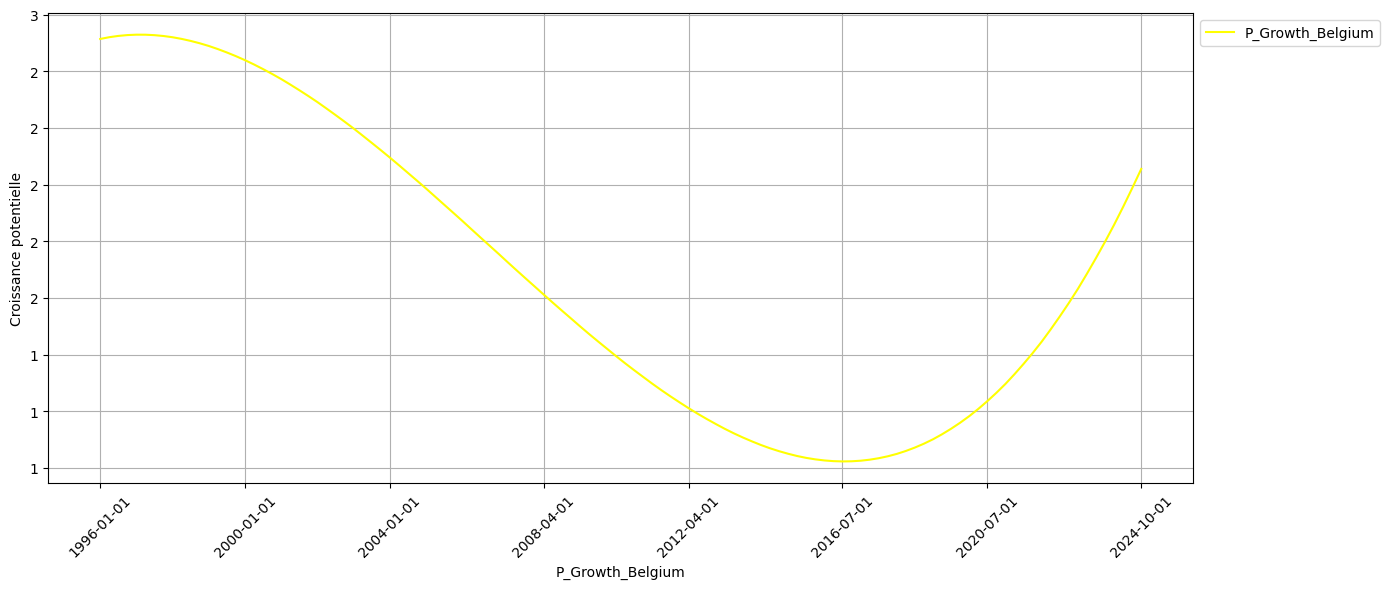

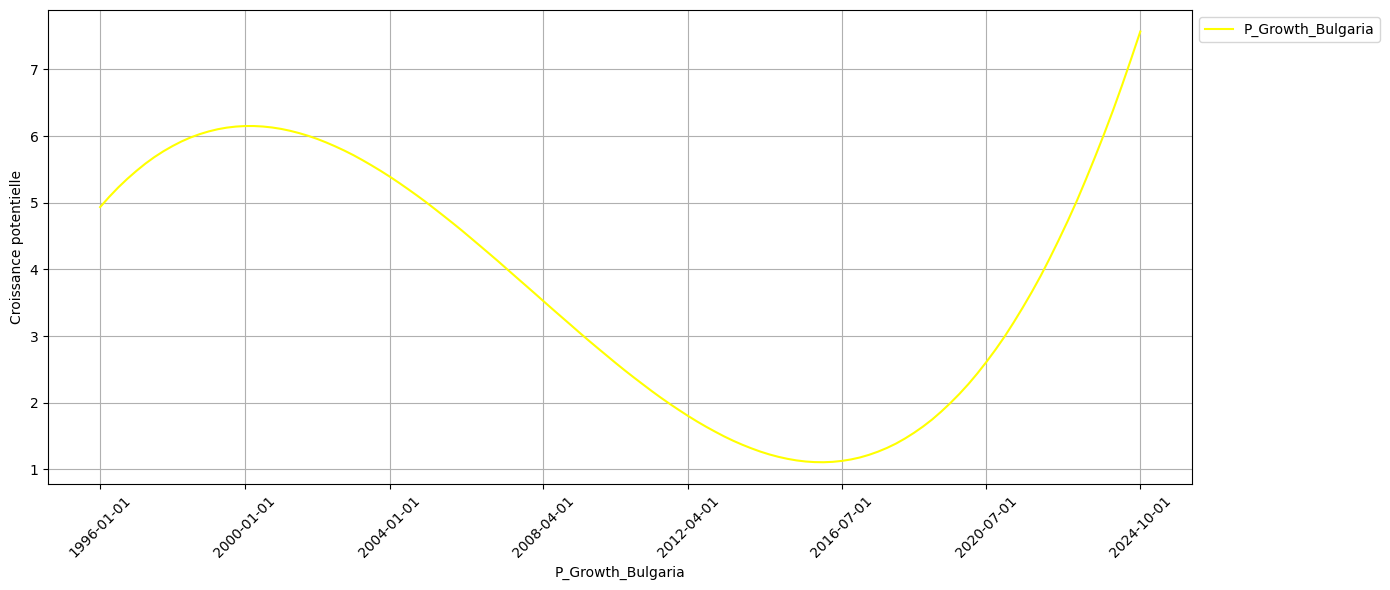

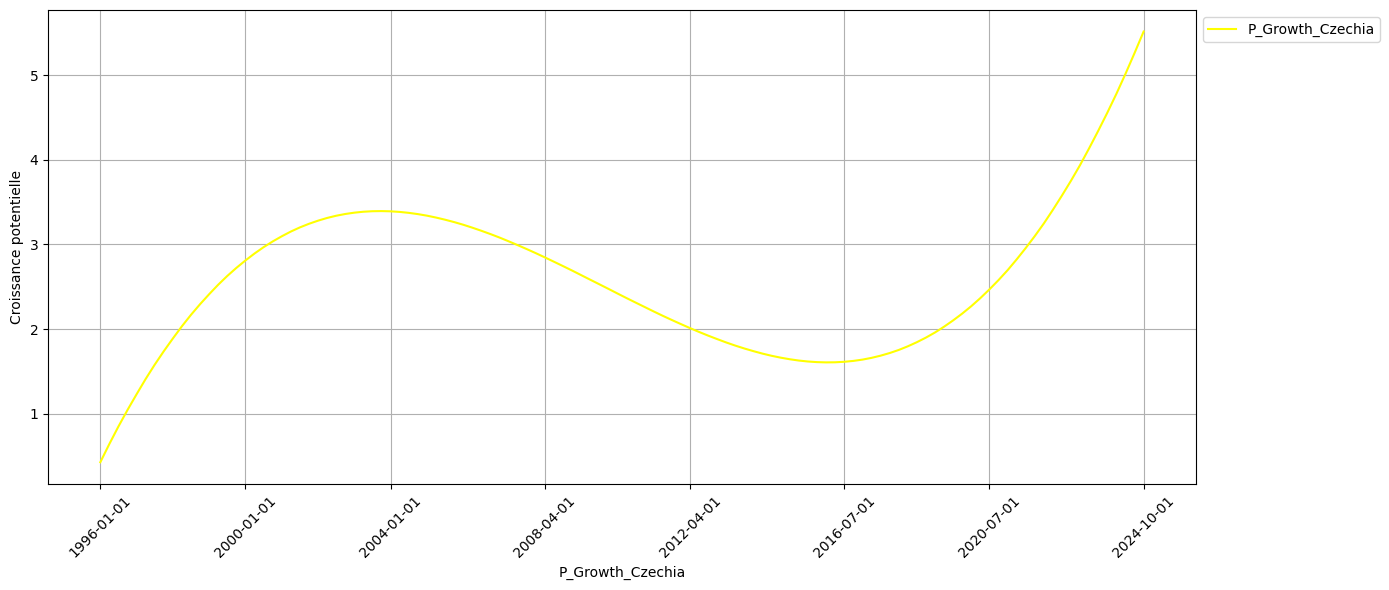

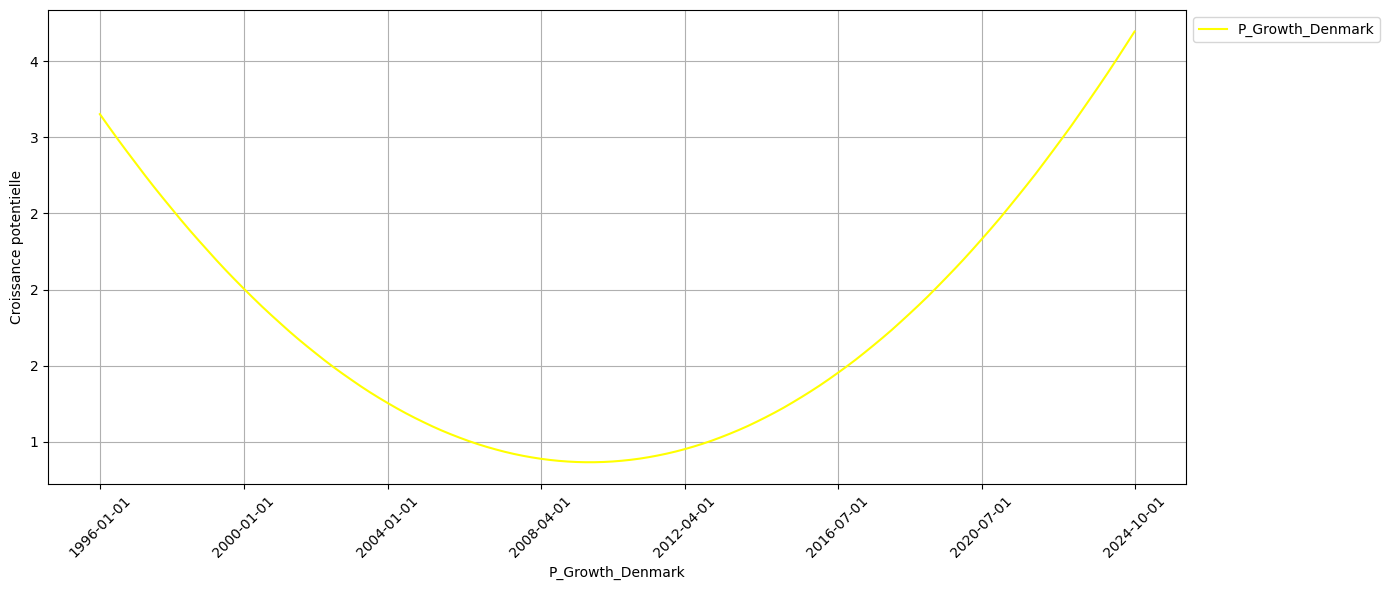

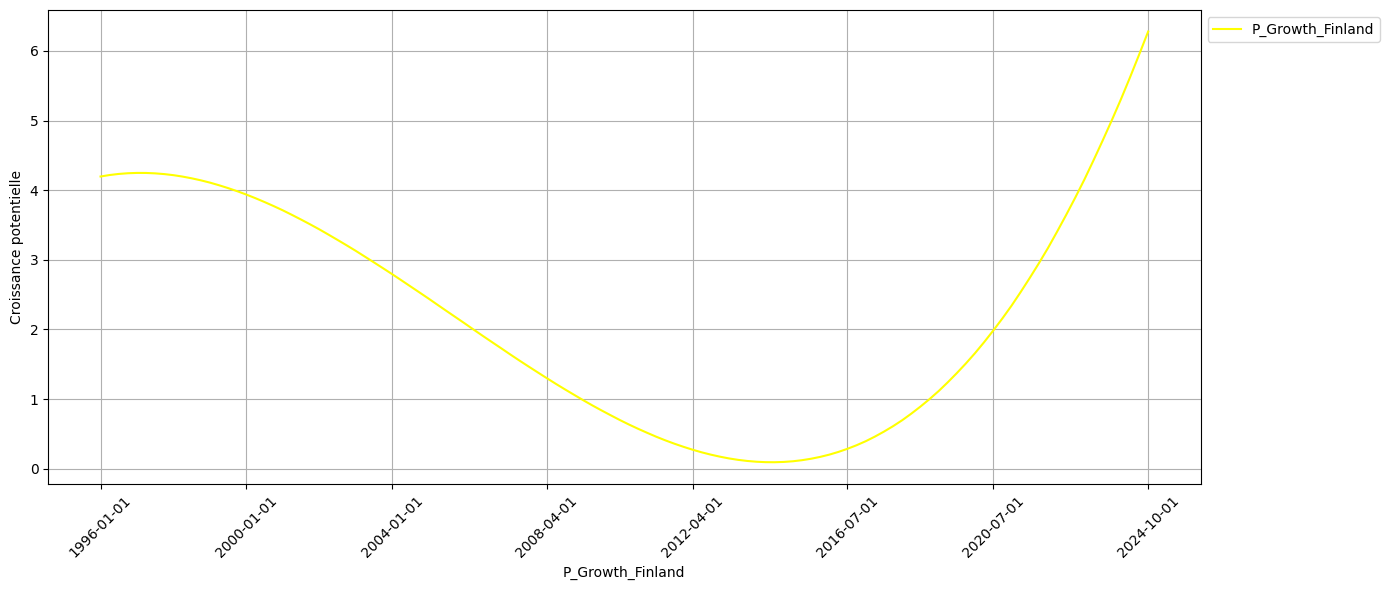

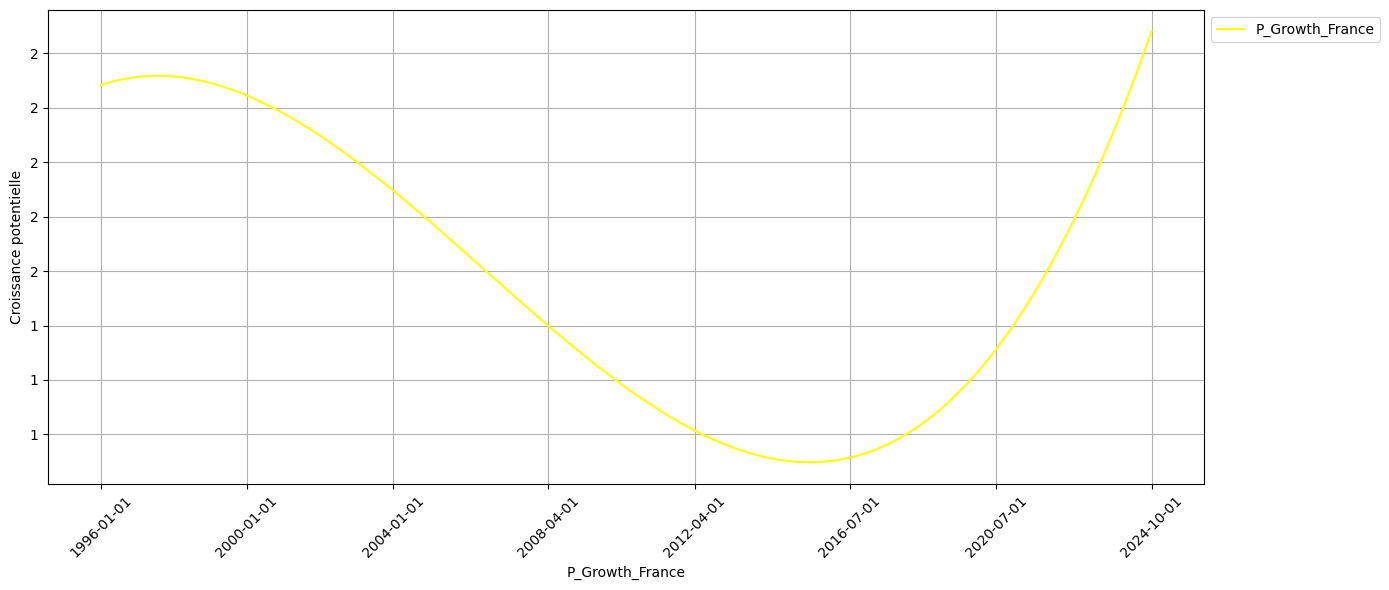

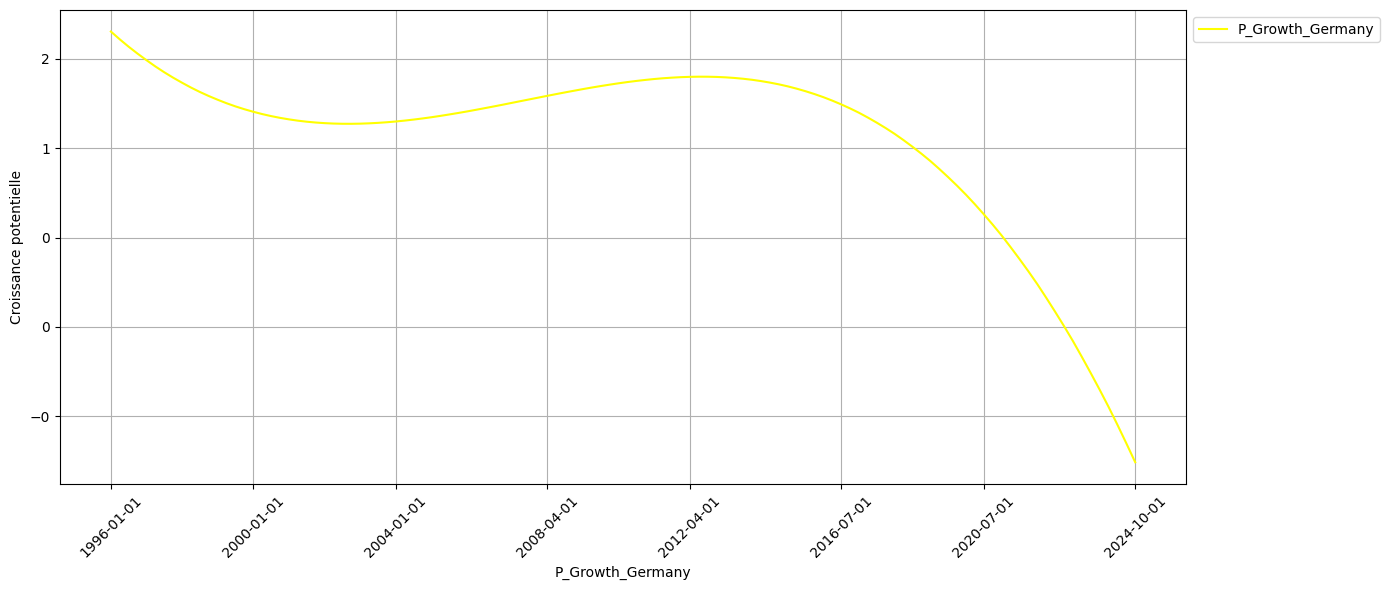

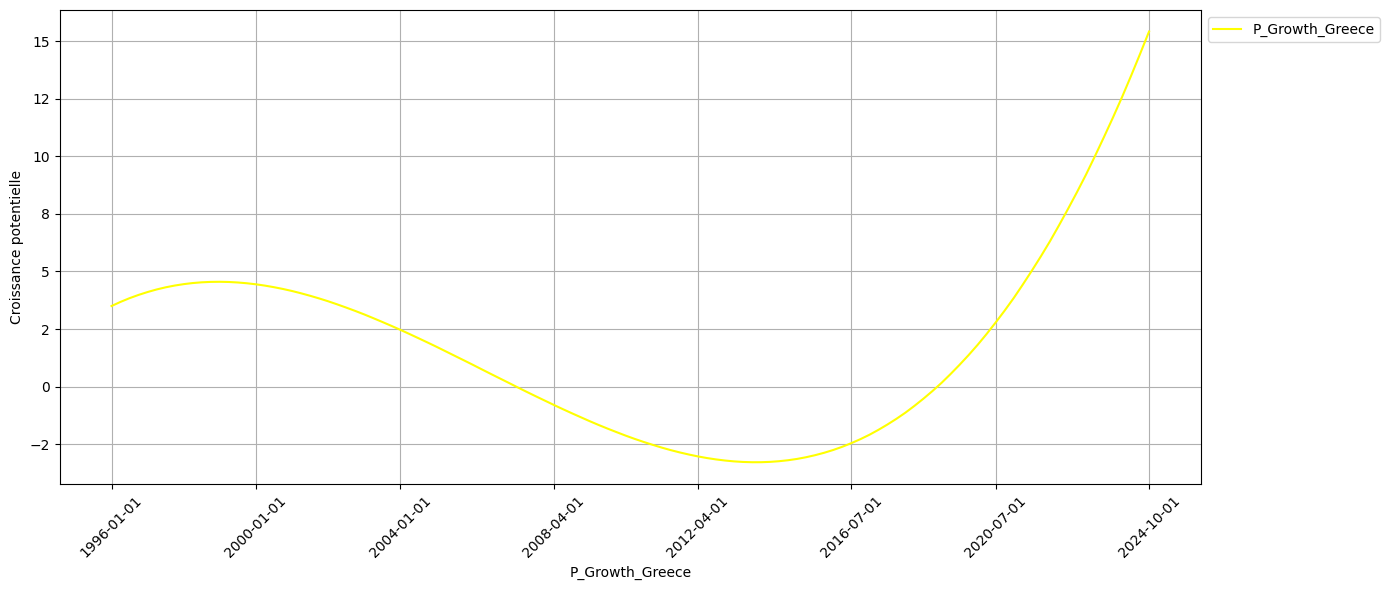

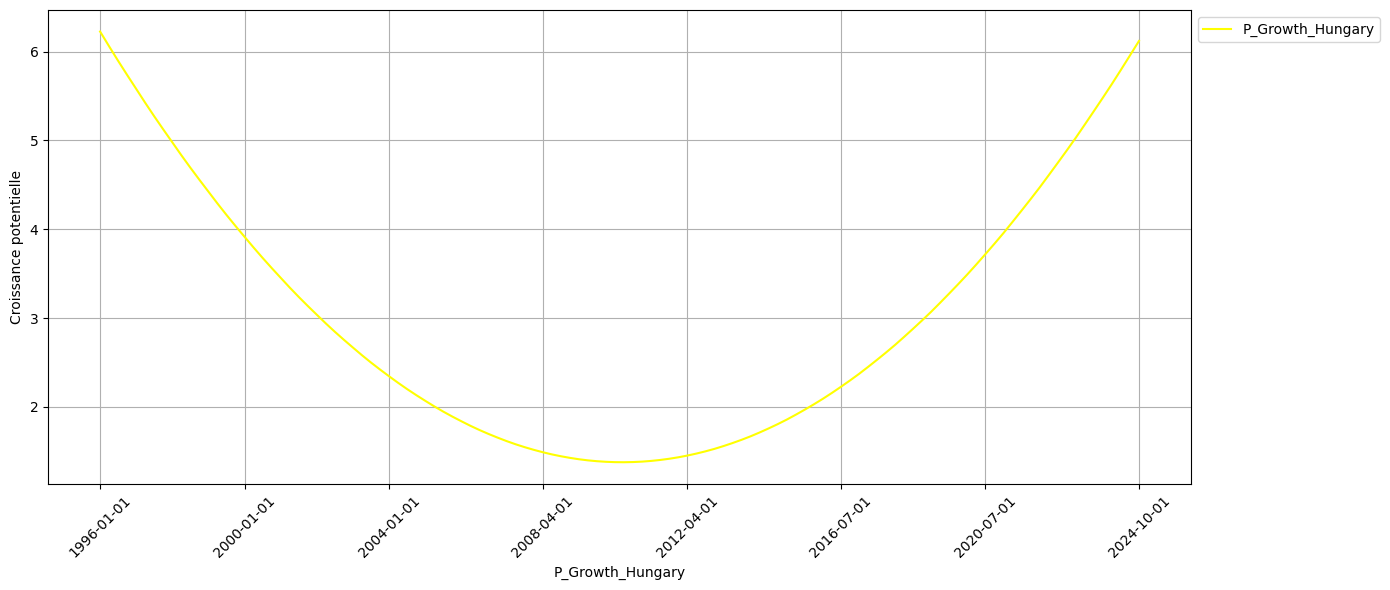

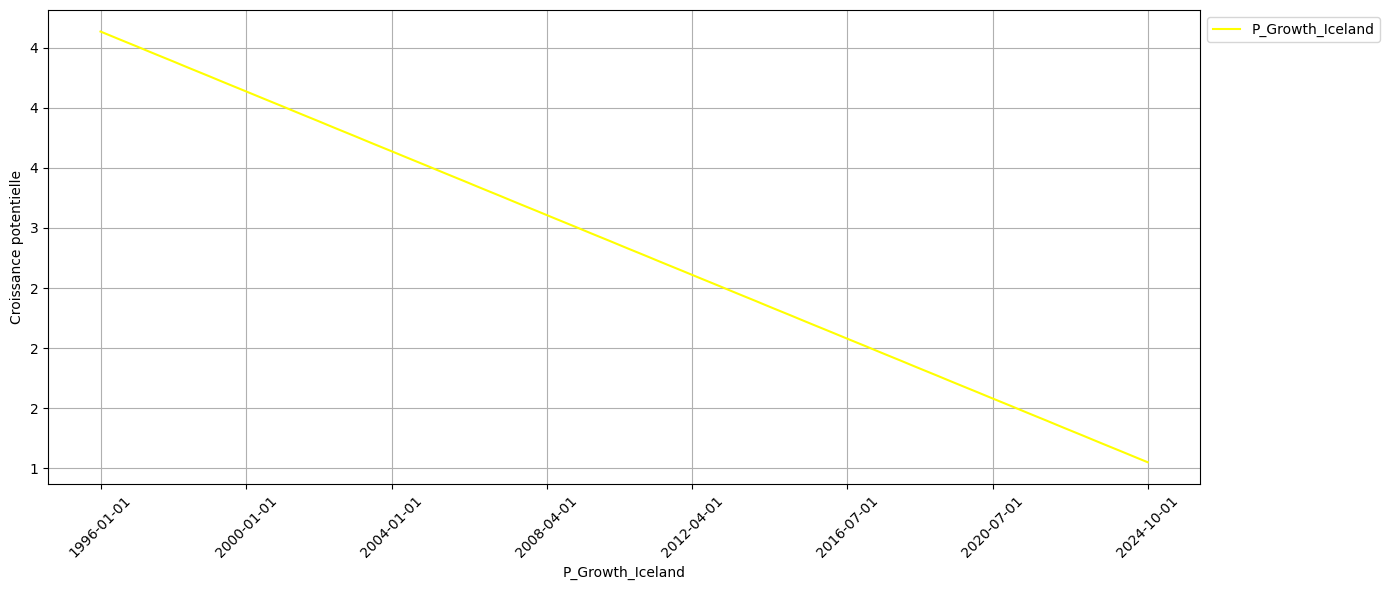

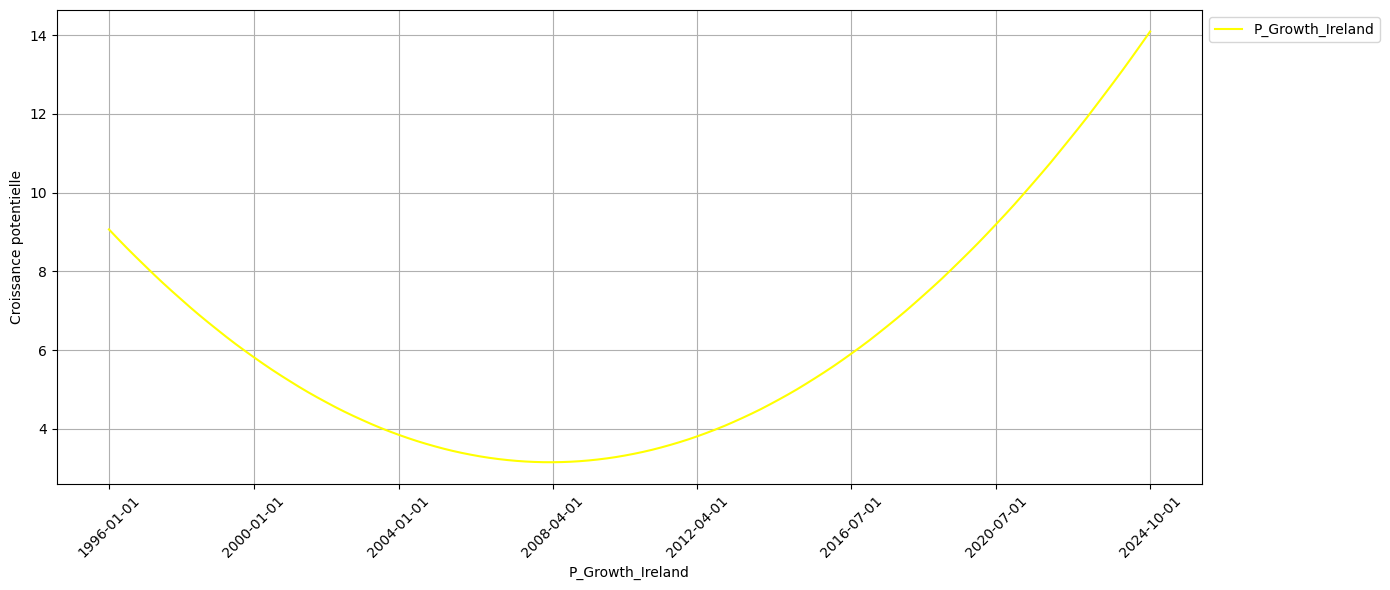

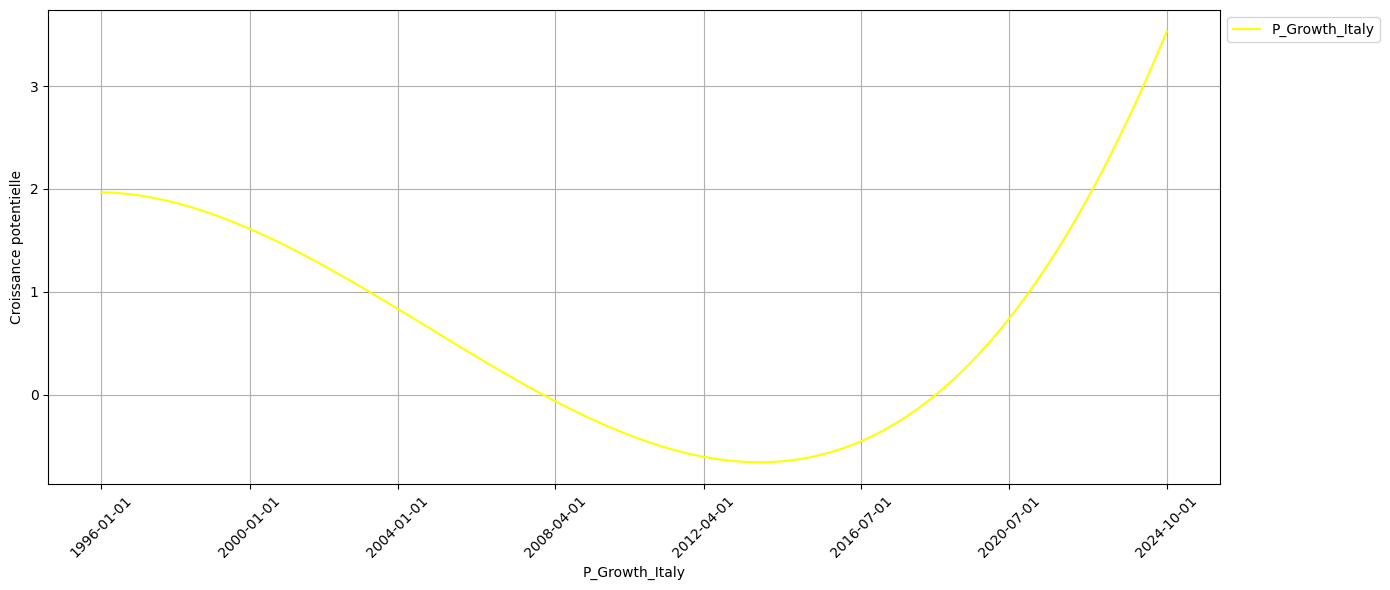

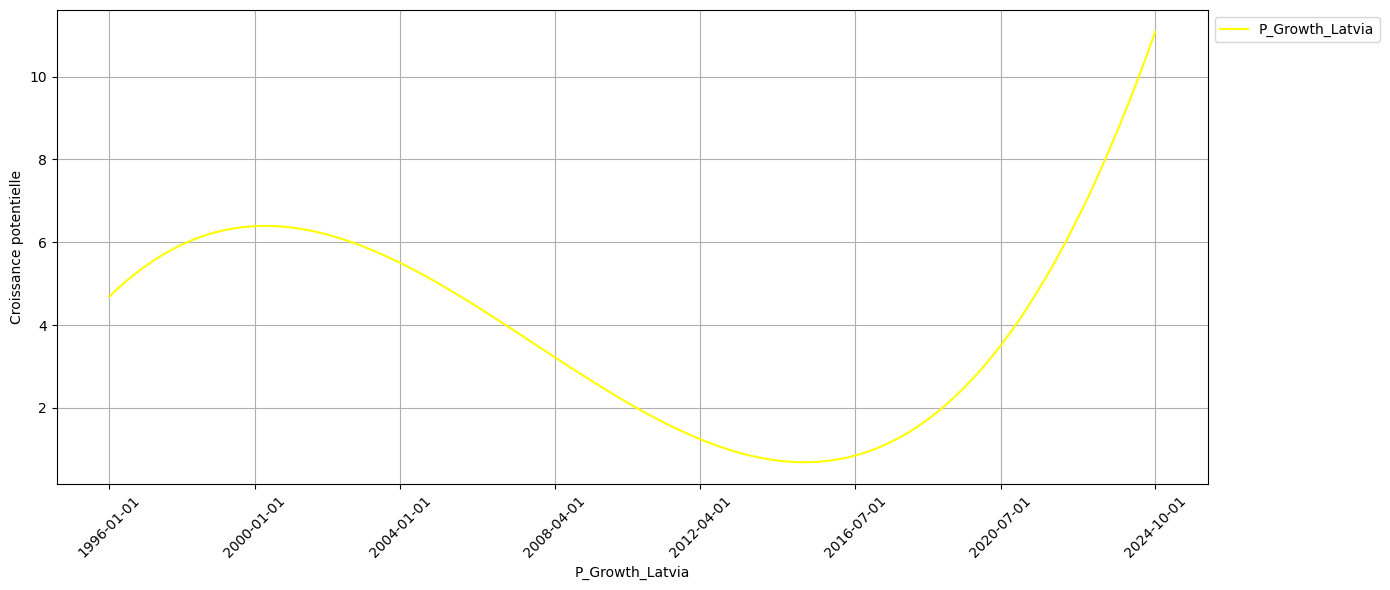

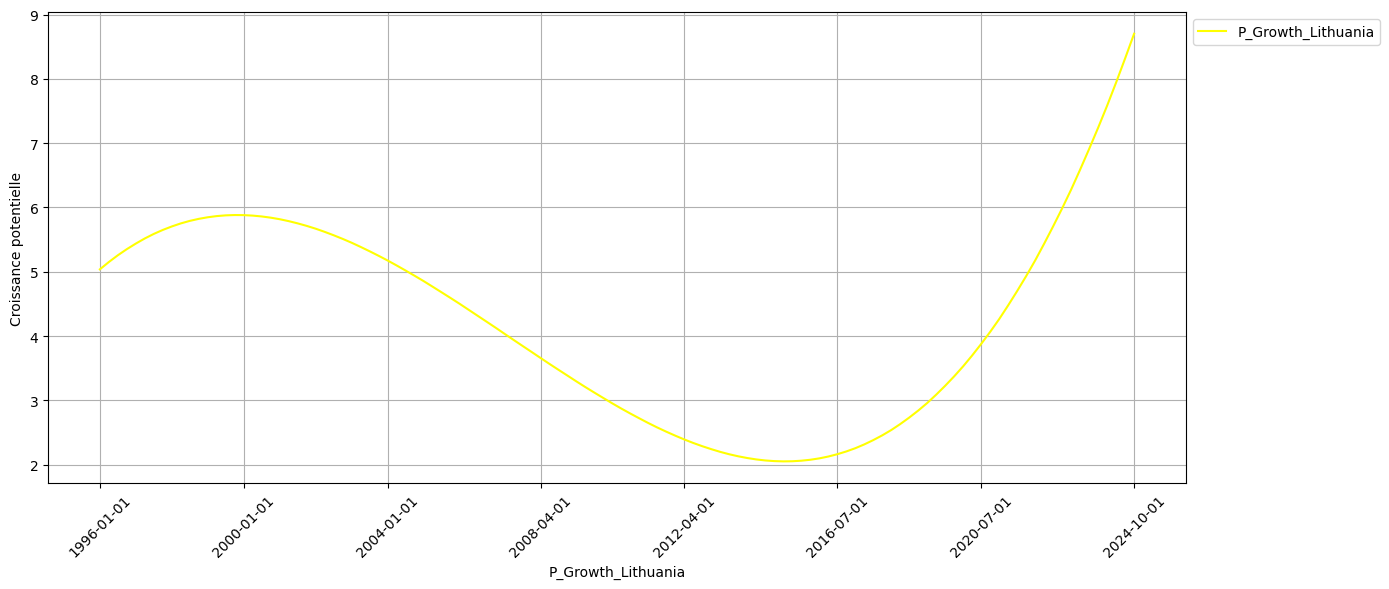

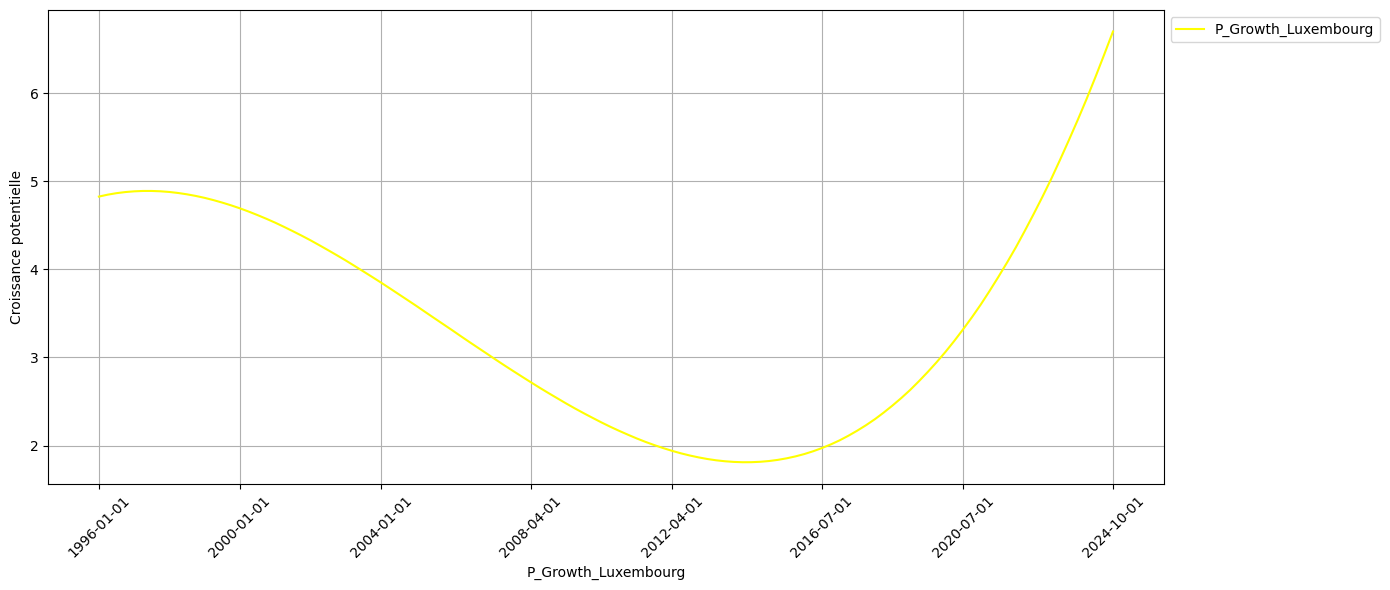

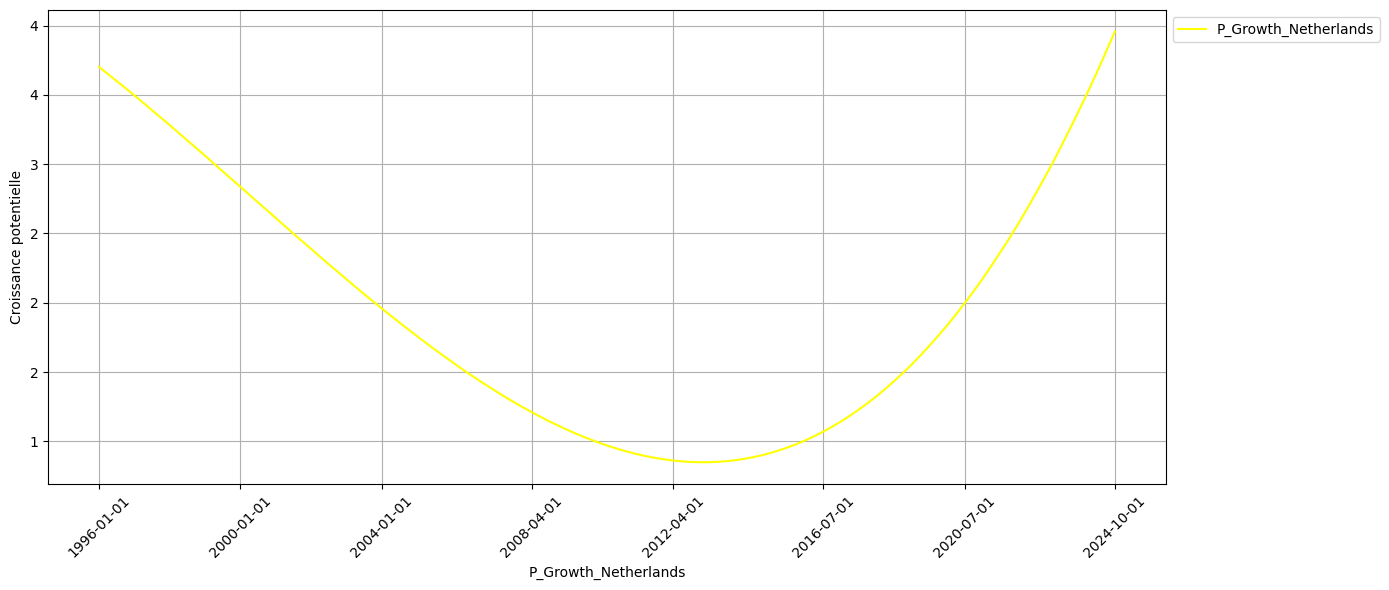

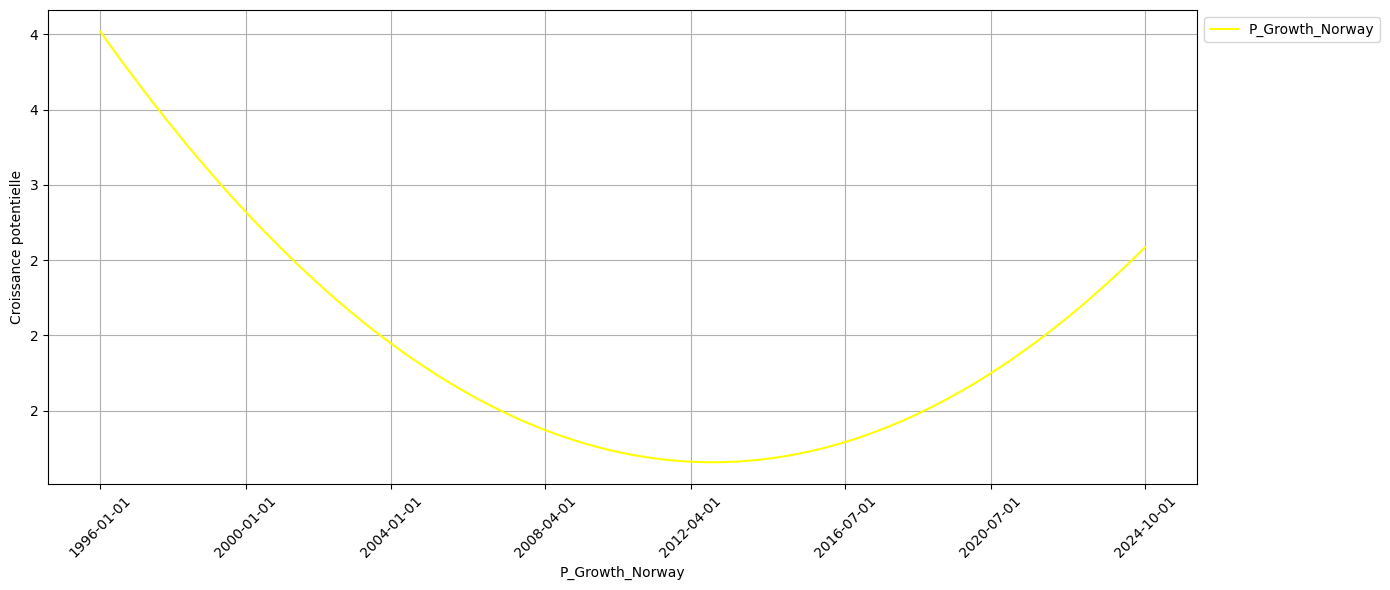

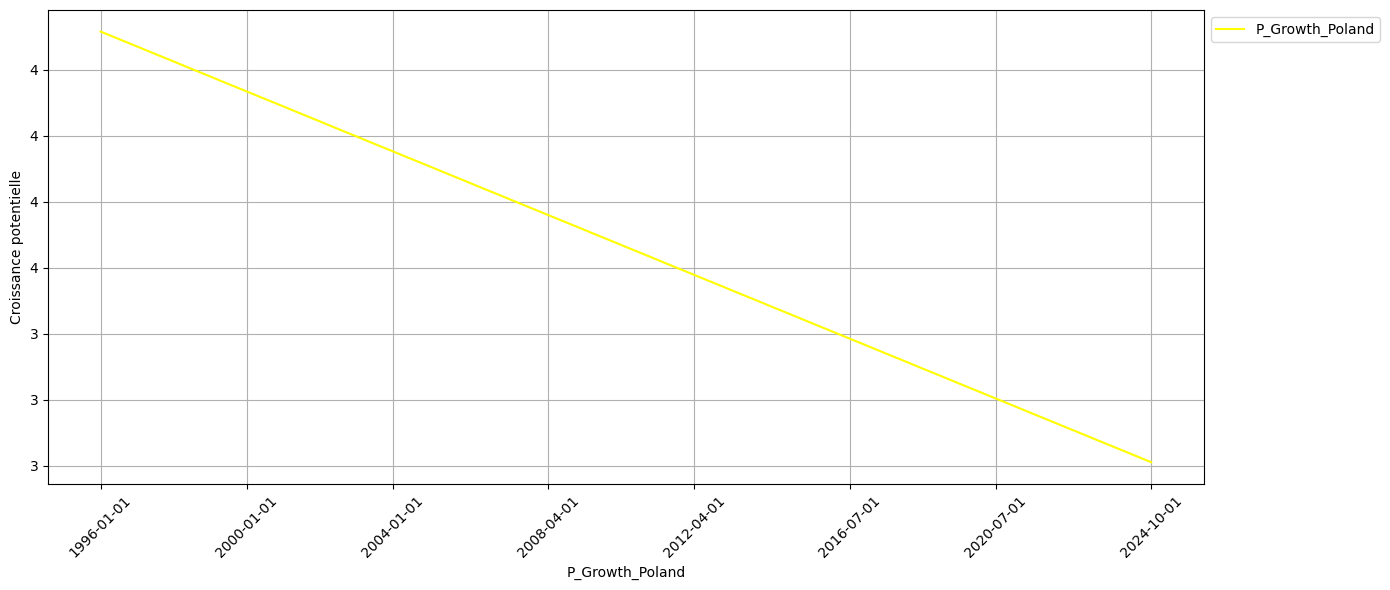

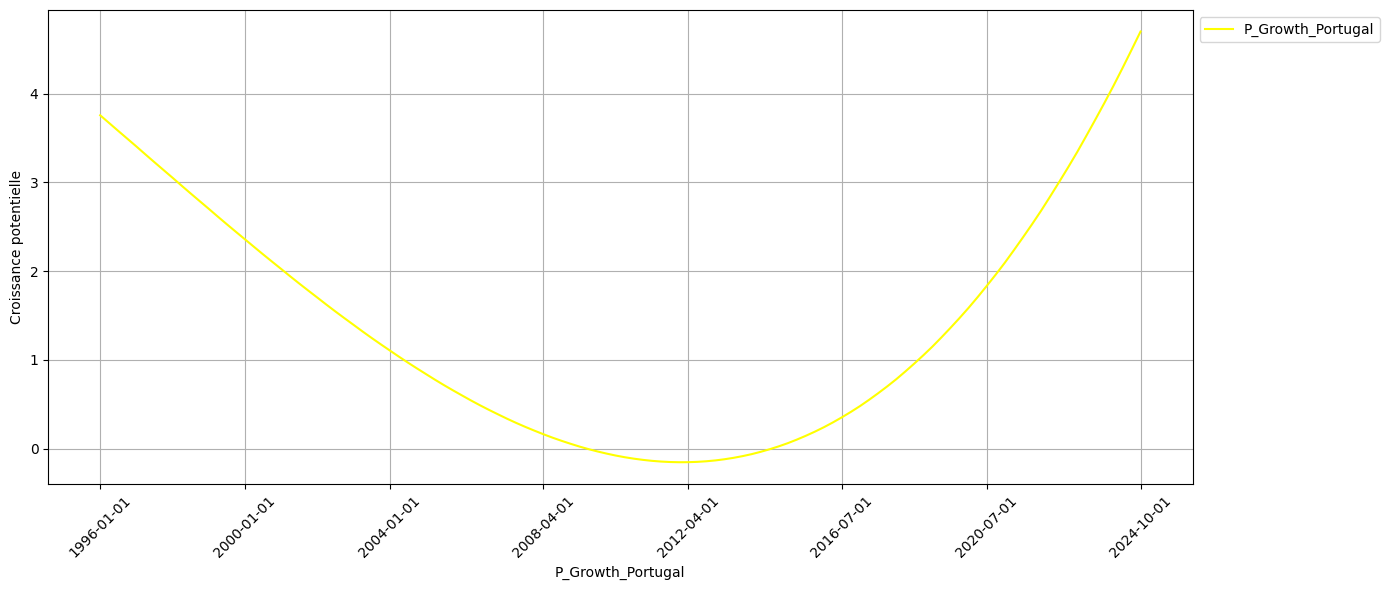

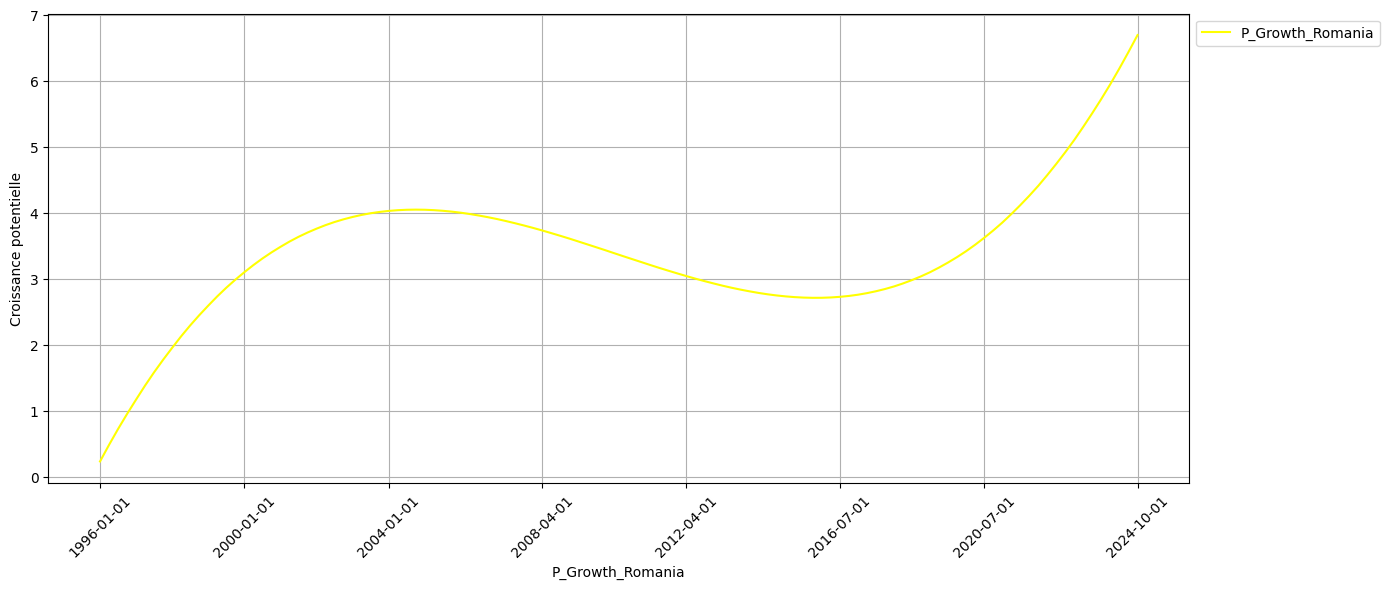

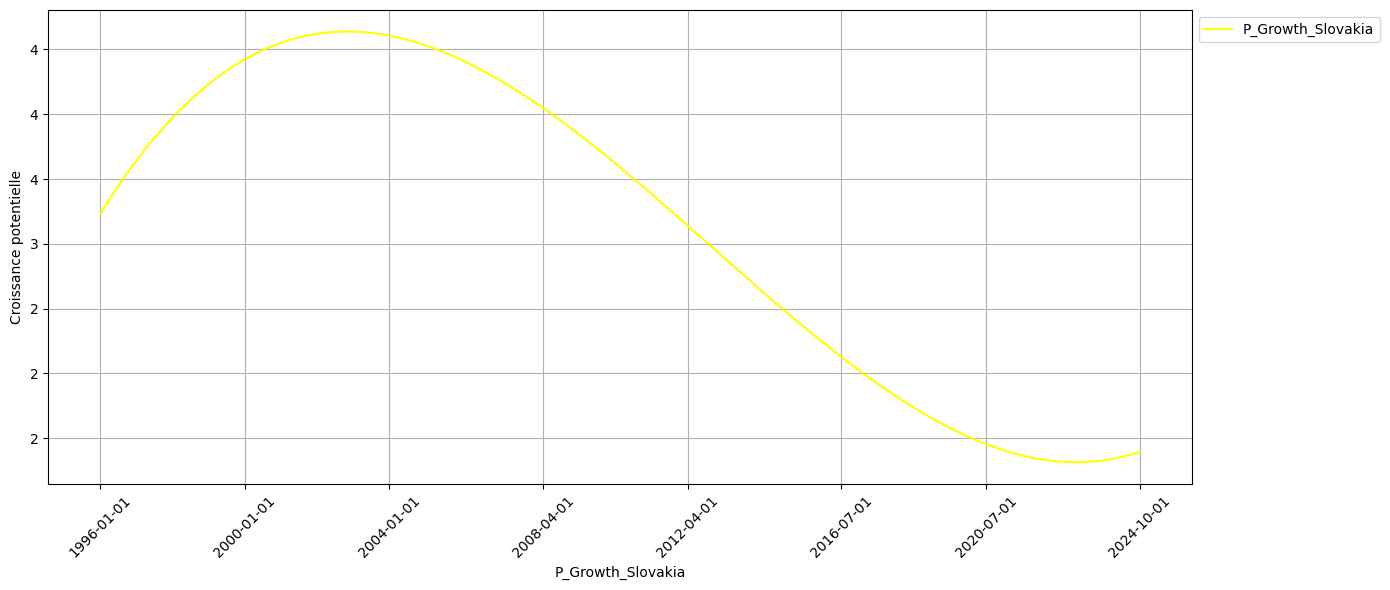

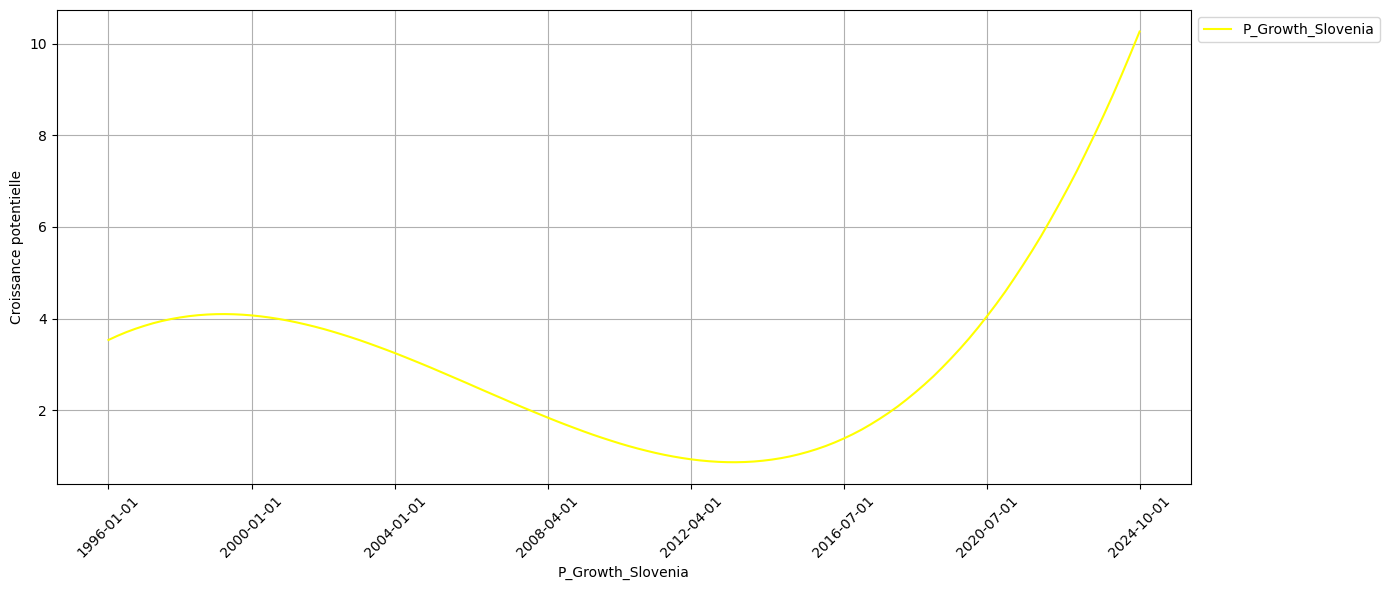

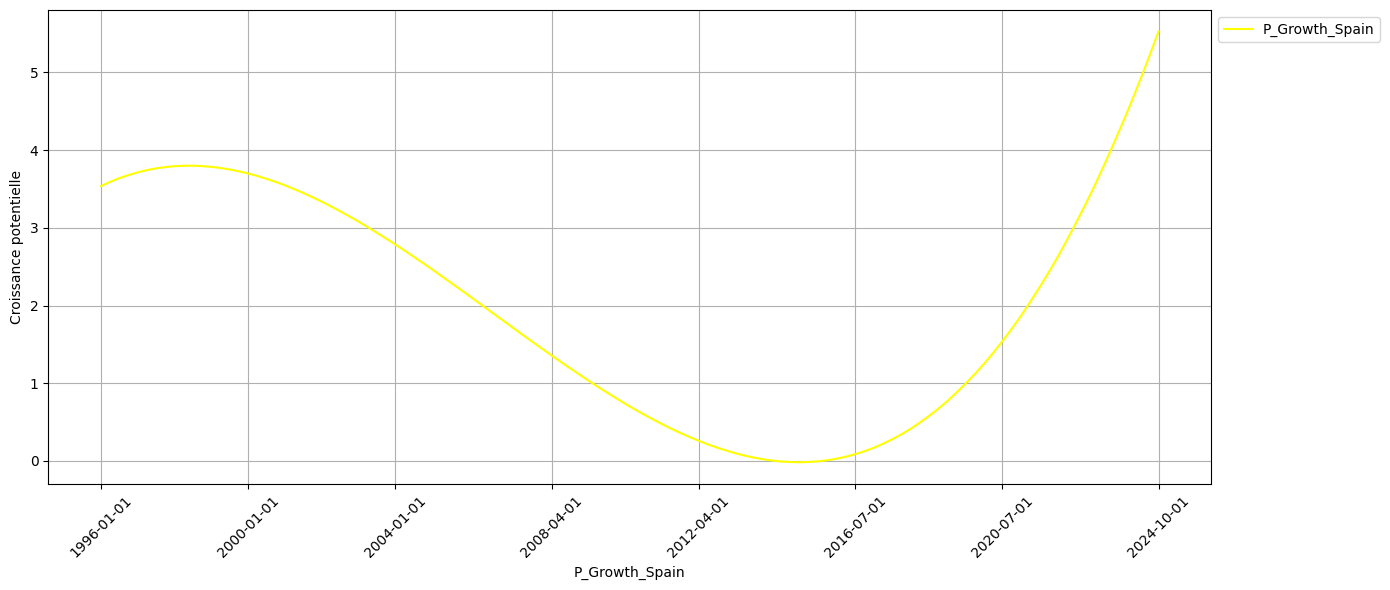

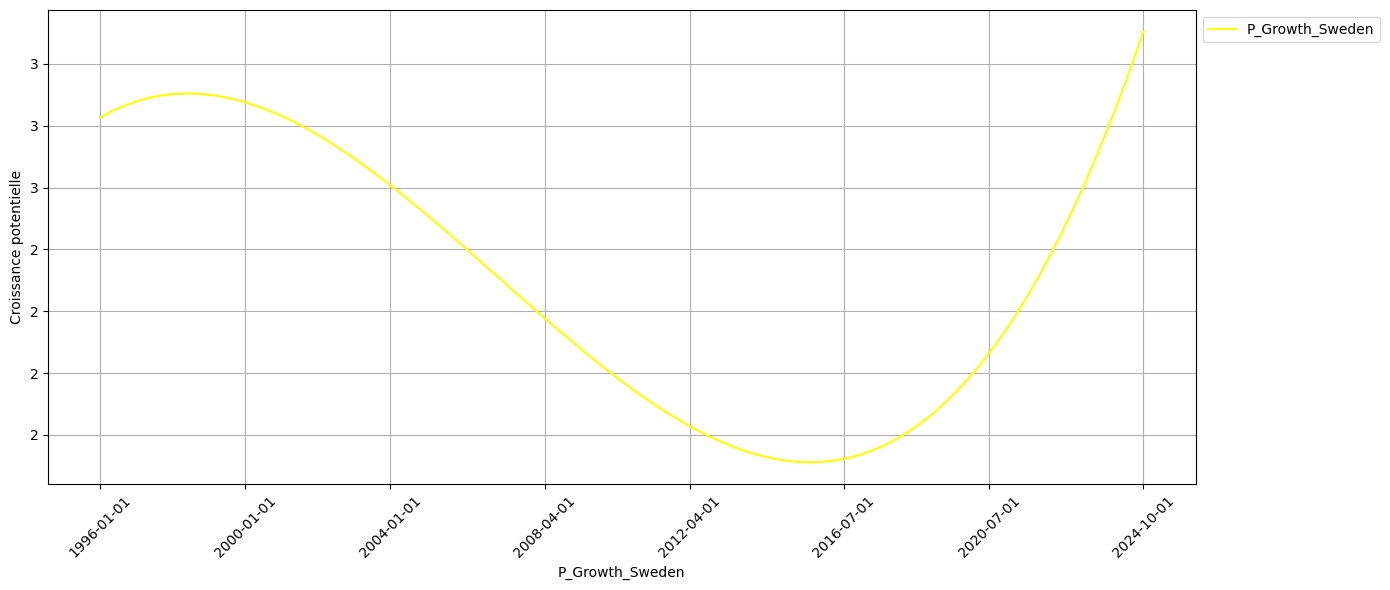

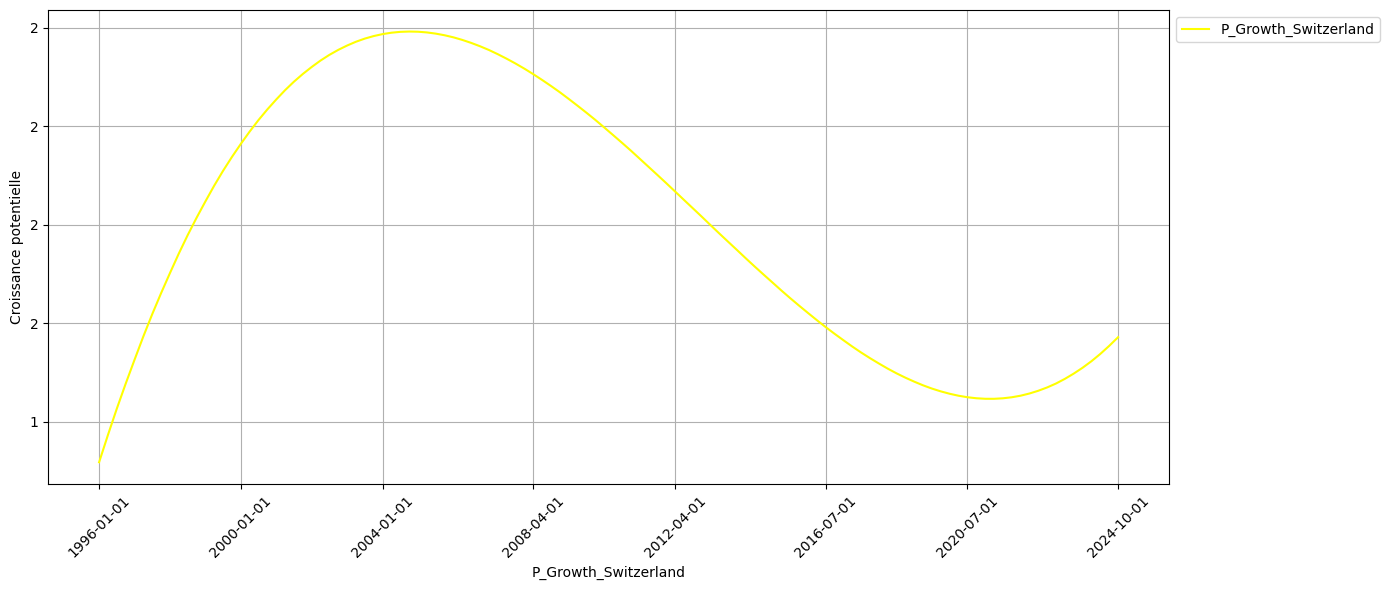

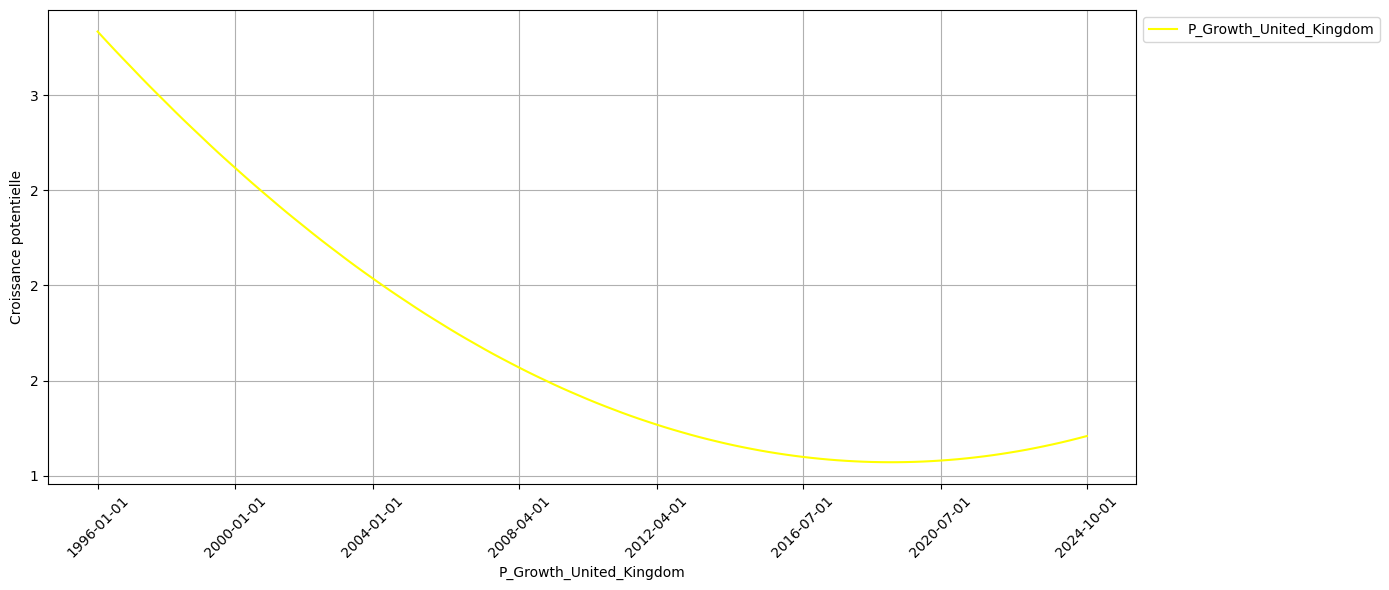

In [93]:
def graph_representation_automation(df):
    noms=list(df.columns)
    for column_name in noms:
        tracer_evolution(df,[column_name],xlabel=f'{column_name}', ylabel="Croissance potentielle" )
        
graph_representation_automation(P_Growth_forecasts)
#tracer_evolution(df_clean_TS, ["P_Growth_Italy"], xlabel="Période", ylabel="Croissance potentielle"


In [ ]:
def tracer_series(series):
    plt.figure(figsize=(10, 4))
    plt.plot(series.index, 
         series.values, 
         marker='o', linestyle='-')
    plt.xlabel("Mois")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [77]:
def tracer_series(series):
    plt.figure(figsize=(10, 4))

    # Tracer toutes les valeurs sauf les 13 dernières
    plt.plot(series.index[:-13],
             series.values[:-13],
             marker='o', linestyle='-', label='Données collectées-interpolées')

    # Tracer les 13 dernières valeurs dans une autre couleur
    plt.plot(series.index[-13:],
             series.values[-13:],
             marker='o', linestyle='-', color='red', label='les 13 dernières valeurs-prédites par régression polynomiale')

    plt.xlabel("Mois")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### P_Growth_Italy <a class="anchor" id="partie241"></a>

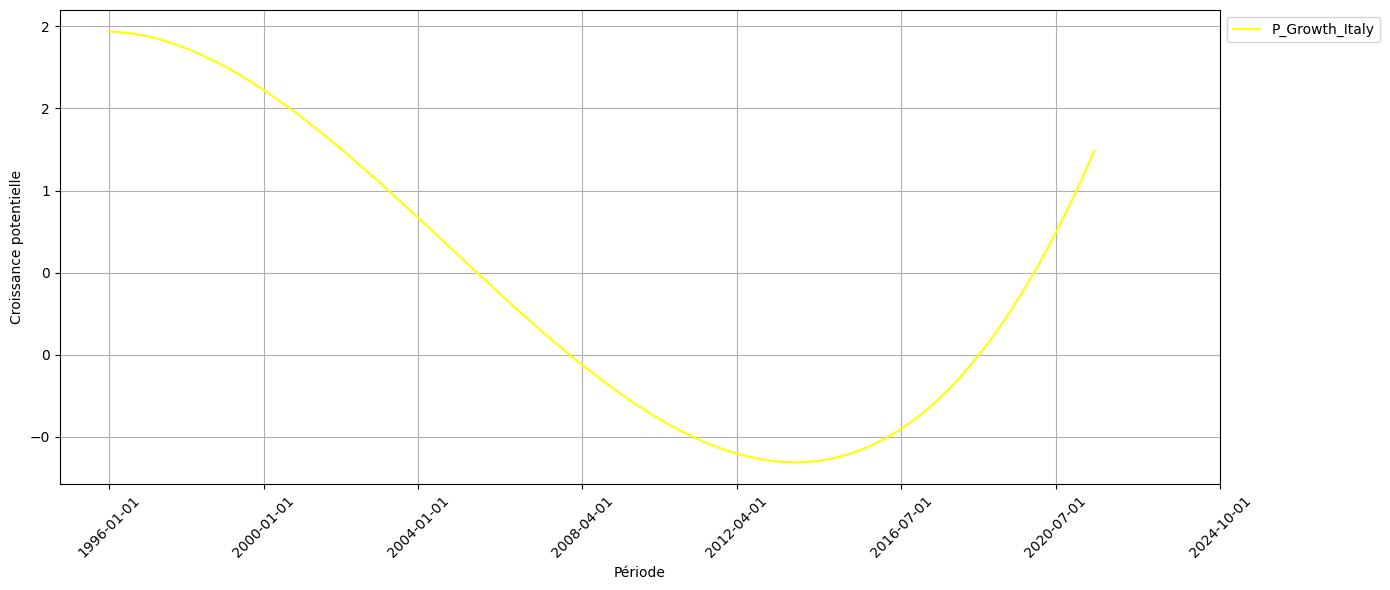

In [ ]:
tracer_evolution(df_clean_TS, ["P_Growth_Italy"], xlabel="Période", ylabel="Croissance potentielle")



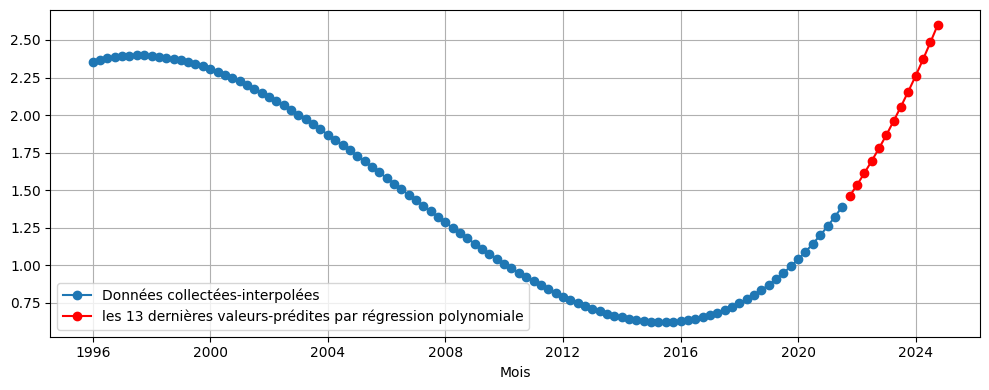

In [ ]:
P_Growth_France_forecast= forecast_polynomial(df_clean_TS, "P_Growth_France")
tracer_series(P_Growth_France_forecast)




#### P_Growth_Bulgaria <a class="anchor" id="partie242"></a>

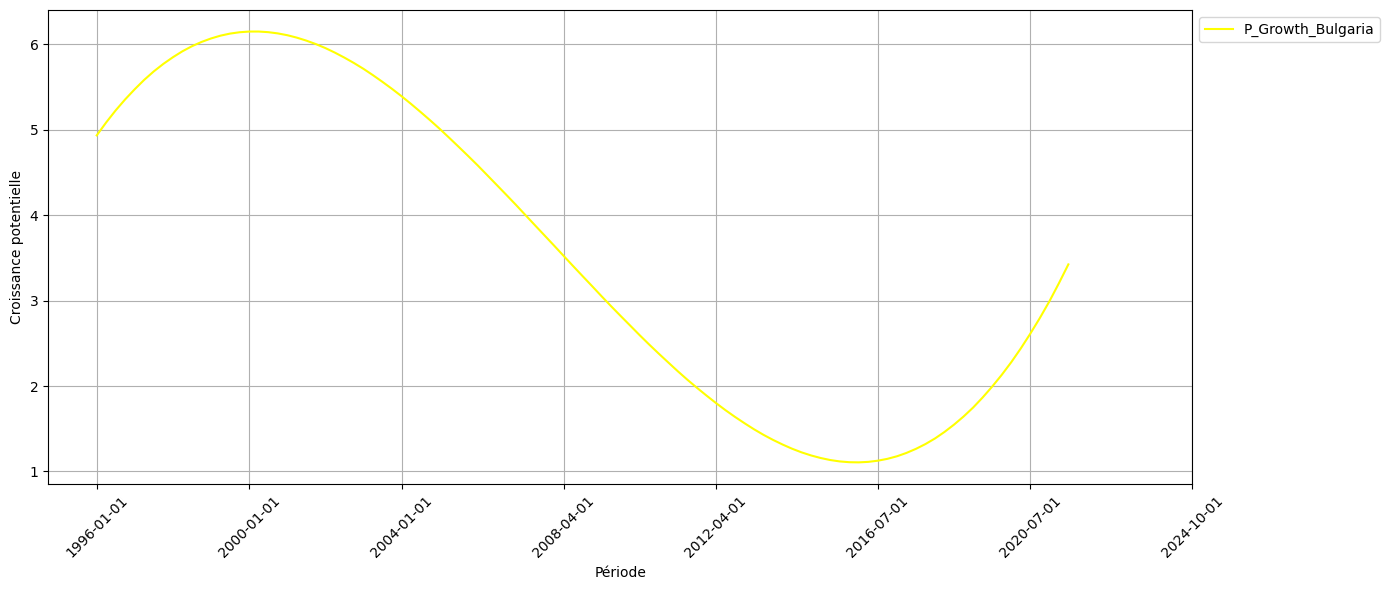

In [56]:
tracer_evolution(df_clean_TS, ["P_Growth_Bulgaria"], xlabel="Période", ylabel="Croissance potentielle")


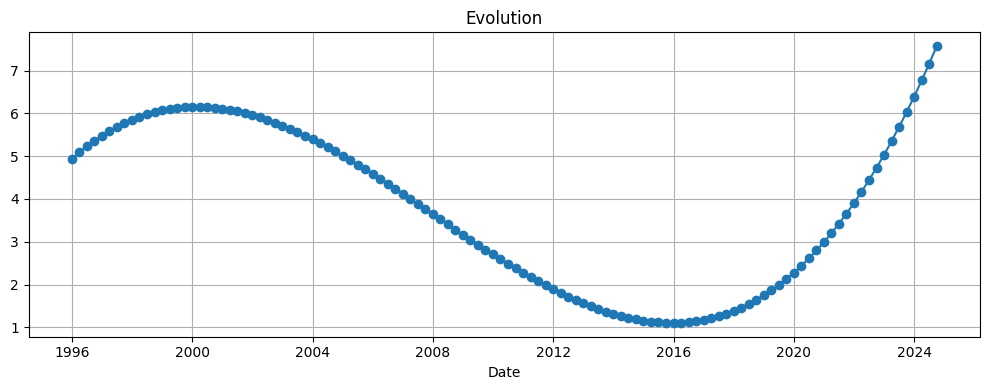

Unnamed: 0
1996-01-01    4.935537
1996-04-01    5.087906
1996-07-01    5.228971
1996-10-01    5.358971
1997-01-01    5.478146
                ...   
2023-10-01    6.030074
2024-01-01    6.391745
2024-04-01    6.768731
2024-07-01    7.161273
2024-10-01    7.569609
Freq: QS-OCT, Name: P_Growth_Bulgaria, Length: 116, dtype: float64


In [58]:
P_Growth_Bulgaria_forecast= forecast_polynomial(df_clean_TS, "P_Growth_Bulgaria")
tracer_series(P_Growth_Bulgaria_forecast)
print(P_Growth_Bulgaria_forecast
      )


#### P_Growth_Czechia <a class="anchor" id="partie243"></a>

#### P_Growth_Denmark <a class="anchor" id="partie244"></a>

### Visualisation progressive du nettoyage<a class="anchor" id="partie3"></a>

Pour visualier le nettoyage progressif des fonctions

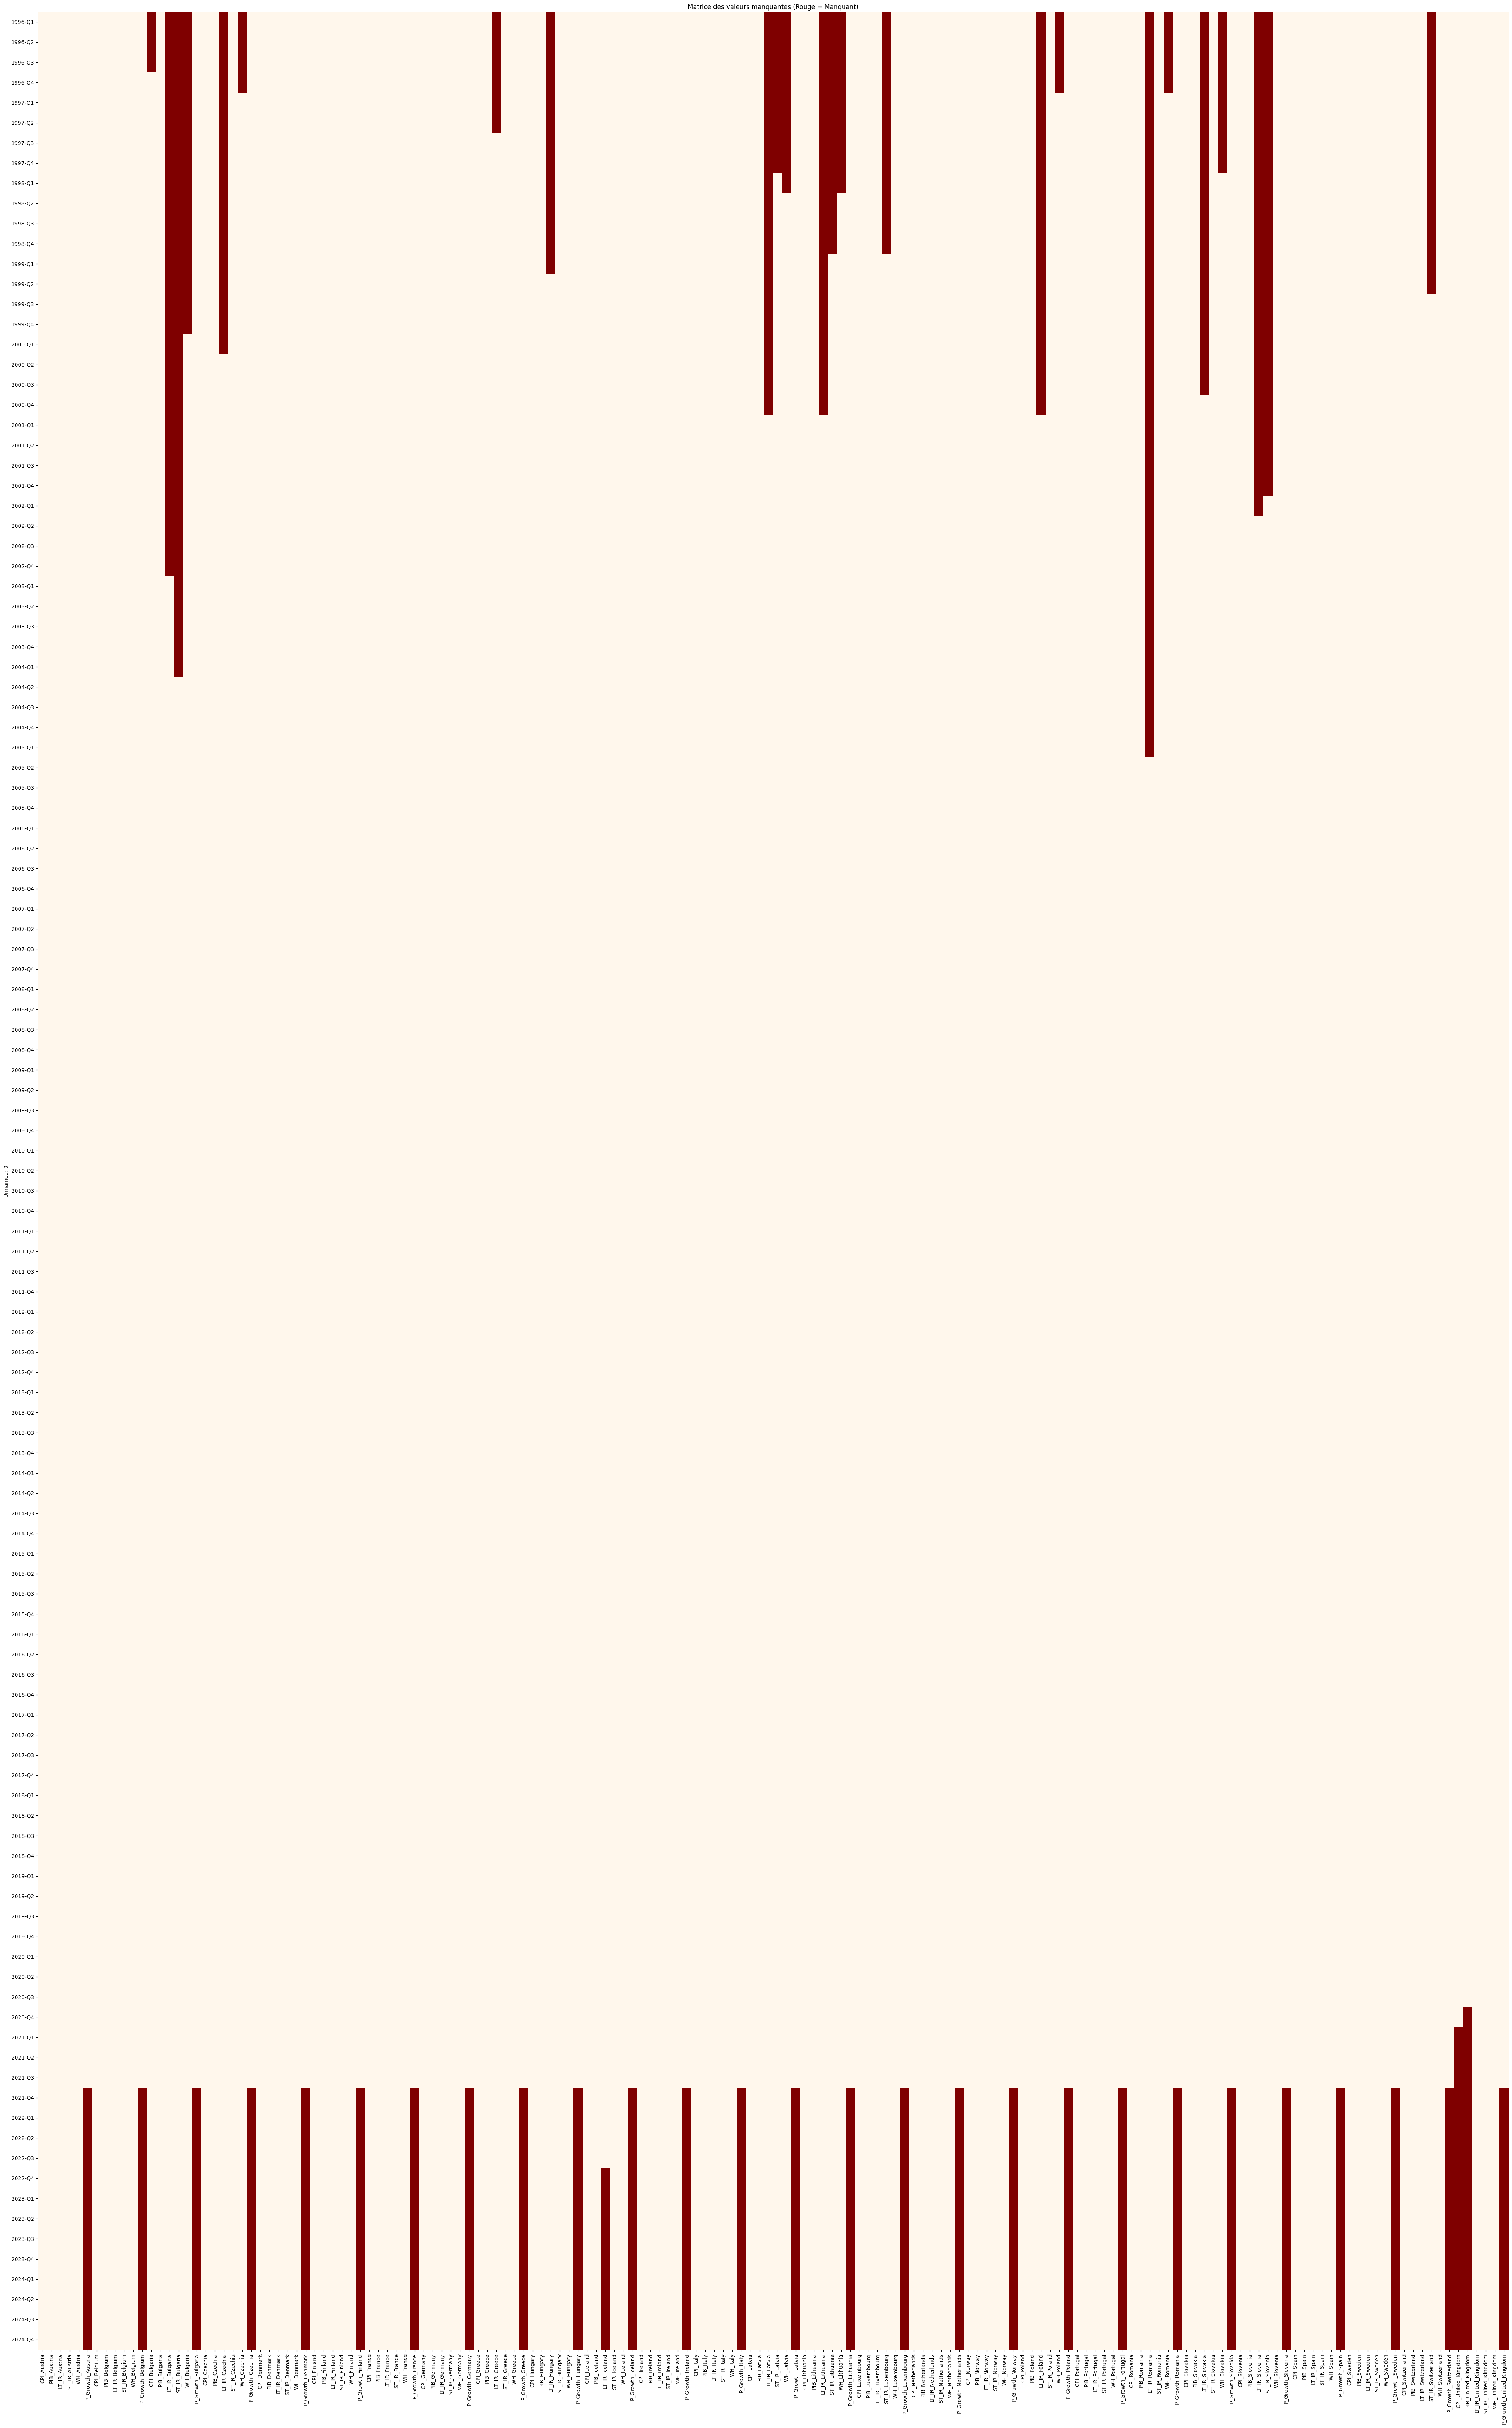

In [65]:
#Pour visualiser le nettoyage progressif des données
df_clean_missing_binary = df_clean.isnull().astype(int)

# Définir la figure avec un affichage interactif
fig, ax = plt.subplots(figsize=(50, 80))

# Utiliser seaborn pour une meilleure visualisation sans grille
sns.heatmap(df_clean_missing_binary, cmap="OrRd", cbar=False, linewidths=0, ax=ax, square=False)

# Ajouter un titre
ax.set_title("Matrice des valeurs manquantes (Rouge = Manquant)")

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Afficher la figure
plt.show()


In [66]:
#Pourcentage de données manquantes par variable
percentage_missing_clean=((df_clean_missing_binary.sum())/df_clean_missing_binary.shape[0])*100

#On ne garde que les colonnes ayant des missing values
percentage_missing_clean=percentage_missing_clean[percentage_missing_clean>0]
percentage_missing_clean = percentage_missing_clean.sort_values(ascending=False)
percentage_missing_clean

LT_IR_Romania              31.896552
ST_IR_Bulgaria             28.448276
LT_IR_Bulgaria             24.137931
LT_IR_Slovenia             21.551724
ST_IR_Slovenia             20.689655
LT_IR_Latvia               17.241379
LT_IR_Lithuania            17.241379
LT_IR_Poland               17.241379
LT_IR_Slovakia             16.379310
PIB_United_Kingdom         14.655172
LT_IR_Czechia              14.655172
WH_Bulgaria                13.793103
CPI_United_Kingdom         13.793103
ST_IR_Switzerland          12.068966
P_Growth_Italy             11.206897
P_Growth_Bulgaria          11.206897
P_Growth_Czechia           11.206897
P_Growth_Denmark           11.206897
P_Growth_France            11.206897
P_Growth_Finland           11.206897
P_Growth_Belgium           11.206897
P_Growth_Austria           11.206897
P_Growth_Sweden            11.206897
P_Growth_Spain             11.206897
P_Growth_Romania           11.206897
P_Growth_Slovenia          11.206897
P_Growth_Iceland           11.206897
P